<a href="https://colab.research.google.com/github/chienng27/Flight-Predict/blob/main/Data_Science_FLIGHT_DELAY_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> <b> ✈️ Data-Science FLIGHT-DELAY PREDICTION HIT ✈️

Dự án tập trung vào việc dự đoán độ trễ chuyến bay bằng kỹ thuật học máy, sử dụng kỹ thuật tính năng và thuật toán hồi quy nâng cao để nâng cao độ chính xác. Tập dữ liệu bao gồm thông tin chuyến bay, điều kiện thời tiết và các yếu tố liên quan khác. Mô hình đạt được độ chính xác 80%.

## I.GIỚI THIỆU

### CÂU HỎI NGHIÊN CỨU

Câu hỏi 1: Có thể dự đoán trước thời gian trễ của mỗi chuyến bay không?

Câu hỏi 2: Có quy luật nào cho thời gian hạ cánh và cất cánh không?

## II.SCRAPING

Thu Thập Dữ Liệu Hàng Không Thông Qua API từ AVIATIONEDGE.com : https://aviation-edge.com/v2/public/flightsHistory

Cài đặt thư viện cần thiết

In [ ]:
#install spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.4/spark-3.5.4-bin-hadoop3.tgz
!tar xf spark-3.5.4-bin-hadoop3.tgz
!pip install -q findspark

^C
tar: spark-3.5.4-bin-hadoop3.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
import os
#import findspark
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/content/spark-3.5.4-bin-hadoop3"
#findspark.init()
import requests
import pandas as pd
from datetime import datetime, timedelta
from google.colab import userdata
import matplotlib.pyplot as plt
from pyspark.sql.functions import unix_timestamp, col, monotonically_increasing_id, when
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType, IntegerType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler,Imputer
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.sql import functions as F
import lightgbm as lgb
import numpy as np
from pyspark.ml.classification import RandomForestClassifier



/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Tạo SparkSession
spark = SparkSession.builder.appName("Trainning Model").getOrCreate()

Gắn kết Google Drive trong Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Xây dựng chương trình lấy dữ liệu từ các sân bay

Do với mỗi request chỉ có thể có được dữ liệu 31 ngày , nên ta sẽ cần dựng hàm 12 tháng để lấy dữ liệu trong 1 năm của từng sân bay . Ở đây ta sẽ lấy các sân bay ở Cần Thơ (VCA) , Hà Nội (HAN) , Hải Phòng (HAH), Hồ Chí Minh (SGN) , Đà Nẵng (DAD) , Phú Quốc (PQC) .

Hàm Tạo Ngày Tháng

In [ ]:
def generate_monthly_dates(start_date, months=12):
    for i in range(months):
        month_start = start_date.replace(day=1)
        month_end = (month_start + timedelta(days=32)).replace(day=1) - timedelta(days=1)
        yield month_start.strftime('%Y-%m-%d'), month_end.strftime('%Y-%m-%d')
        start_date = month_start + timedelta(days=32)

Khởi tạo biến

In [ ]:
url = 'https://aviation-edge.com/v2/public/flightsHistory'
params = {
    'key': userdata.get('API_Key')
}
Iata_code=['VCA','HAN','HAH','SGN','DAD','PQC']
Type = ['departure', 'arrival']

NotebookAccessError: Notebook does not have access to secret API_Key

Chạy vòng lặp để lấy dữ liệu các sân bay

In [ ]:
for code in Iata_code:
 for typ in Type:
  start_date = datetime(2023, 11, 1)
  all_data = pd.DataFrame()
  params['code'] = code
  params['type'] = typ
  for date_from, date_to in generate_monthly_dates(start_date, months=12):
      params['date_from'] = date_from
      params['date_to'] = date_to
      api_response = requests.get(url, params=params).json()

      df = pd.json_normalize(api_response)
      all_data = pd.concat([all_data, df], ignore_index=True)

  all_data.to_csv(f'drive/MyDrive/Colab Notebooks/SVKT/{code}_{typ}.csv', index=False)

  print(f"Dữ liệu đã được lưu vào file drive/MyDrive/Colab Notebooks/SVKT/{code}_{typ}.csv'")

![Hinh1](https://i.imgur.com/LqmbbKy.jpeg)




## III. MERGE DATA

### Gộp file Departure

In [ ]:
import pandas as pd

# Đường dẫn đến các tệp CSV
file_1_path = "drive/MyDrive/SVKT/RAW_airport_data/VCA/VCA_departure.csv"
file_2_path = "drive/MyDrive/SVKT/RAW_airport_data/SGN/SGN_departure.csv"
file_3_path = "drive/MyDrive/SVKT/RAW_airport_data/PQC/PQC_departure.csv"
file_4_path = "drive/MyDrive/SVKT/RAW_airport_data/HAN/HAN_departure.csv"
file_5_path = "drive/MyDrive/SVKT/RAW_airport_data/HAH/HAH_departure.csv"
file_6_path = "drive/MyDrive/SVKT/RAW_airport_data/DAD/DAD_departure.csv"

# Đọc từng tệp CSV thành DataFrame
df1 = pd.read_csv(file_1_path)
df2 = pd.read_csv(file_2_path)
df3 = pd.read_csv(file_3_path)
df4 = pd.read_csv(file_4_path)
df5 = pd.read_csv(file_5_path)
df6 = pd.read_csv(file_6_path)
# Gộp các DataFrame lại thành một
merged_df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)

# Lưu kết quả vào một tệp mới
output_path = "drive/MyDrive/SVKT/RAW_airport_data/Departure_data.csv"
merged_df.to_csv(output_path, index=False)

print(f"Tệp đã được gộp thành công và lưu tại: {output_path}")

<ipython-input-10-0a6440842819>:13: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(file_2_path)
<ipython-input-10-0a6440842819>:14: DtypeWarning: Columns (30,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv(file_3_path)
<ipython-input-10-0a6440842819>:15: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df4 = pd.read_csv(file_4_path)
<ipython-input-10-0a6440842819>:17: DtypeWarning: Columns (4,28,30,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df6 = pd.read_csv(file_6_path)


Tệp đã được gộp thành công và lưu tại: drive/MyDrive/SVKT/RAW_airport_data/Departure_data.csv


#### Đọc data departure

In [ ]:
data_Departure = pd.read_csv("drive/MyDrive/SVKT/RAW_airport_data/Departure_data.csv")
data_Departure.info()

<ipython-input-11-fc813ffe9fcb>:1: DtypeWarning: Columns (31,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  data_Departure = pd.read_csv("drive/MyDrive/SVKT/RAW_airport_data/Departure_data.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615592 entries, 0 to 615591
Data columns (total 36 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   type                          615586 non-null  object 
 1   status                        615586 non-null  object 
 2   departure.iataCode            615586 non-null  object 
 3   departure.icaoCode            615586 non-null  object 
 4   departure.scheduledTime       615586 non-null  object 
 5   departure.actualTime          439488 non-null  object 
 6   departure.estimatedRunway     439488 non-null  object 
 7   departure.actualRunway        439488 non-null  object 
 8   arrival.iataCode              615586 non-null  object 
 9   arrival.icaoCode              615586 non-null  object 
 10  arrival.terminal              424849 non-null  object 
 11  arrival.scheduledTime         615586 non-null  object 
 12  arrival.estimatedTime         430891 non-nul

#### Đổi tên cột departure

In [ ]:
# rename các cột "." -> "_"
data_Departure.columns = data_Departure.columns.str.replace(r"\.", "_", regex=True)

#### Vẽ đồ thị phân tán departure

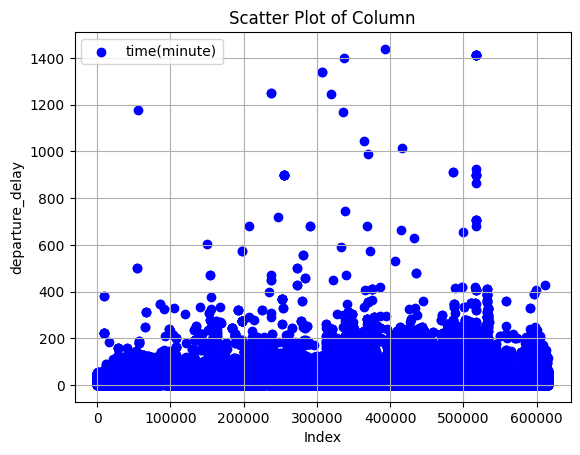

In [ ]:
# Vẽ đồ thị phân tán
plt.scatter(data_Departure.index, data_Departure["departure_delay"], color='blue', label='time(minute)')

# Thêm nhãn và tiêu đề
plt.title('Scatter Plot of Column')
plt.xlabel('Index')
plt.ylabel('departure_delay')
plt.legend()
plt.grid(True)

# Hiển thị đồ thị
plt.show()

### Gộp file Arrival

In [ ]:
import pandas as pd

# Đường dẫn đến các tệp CSV
file_1_path = "drive/MyDrive/SVKT/RAW_airport_data/VCA/VCA_arrival.csv"
file_2_path = "drive/MyDrive/SVKT/RAW_airport_data/SGN/SGN_arrival.csv"
file_3_path = "drive/MyDrive/SVKT/RAW_airport_data/PQC/PQC_arrival.csv"
file_4_path = "drive/MyDrive/SVKT/RAW_airport_data/HAN/HAN_arrival.csv"
file_5_path = "drive/MyDrive/SVKT/RAW_airport_data/HAH/HAH_arrival.csv"
file_6_path = "drive/MyDrive/SVKT/RAW_airport_data/DAD/DAD_arrival.csv"

# Đọc từng tệp CSV thành DataFrame
df1 = pd.read_csv(file_1_path)
df2 = pd.read_csv(file_2_path)
df3 = pd.read_csv(file_3_path)
df4 = pd.read_csv(file_4_path)
df5 = pd.read_csv(file_5_path)
df6 = pd.read_csv(file_6_path)
# Gộp các DataFrame lại thành một
merged_df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)

# Lưu kết quả vào một tệp mới
output_path = "drive/MyDrive/SVKT/RAW_airport_data/Arrival_data.csv"
merged_df.to_csv(output_path, index=False)

print(f"Tệp đã được gộp thành công và lưu tại: {output_path}")

<ipython-input-13-b47c63a8c247>:13: DtypeWarning: Columns (34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(file_2_path)
<ipython-input-13-b47c63a8c247>:14: DtypeWarning: Columns (0,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv(file_3_path)
<ipython-input-13-b47c63a8c247>:15: DtypeWarning: Columns (33,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df4 = pd.read_csv(file_4_path)
<ipython-input-13-b47c63a8c247>:17: DtypeWarning: Columns (9,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df6 = pd.read_csv(file_6_path)


Tệp đã được gộp thành công và lưu tại: drive/MyDrive/SVKT/RAW_airport_data/Arrival_data.csv


#### Đọc file arrival

In [ ]:
data_Arrival = pd.read_csv("drive/MyDrive/SVKT/RAW_airport_data/Arrival_data.csv")
data_Arrival.info()

<ipython-input-14-63b29b65cf5e>:1: DtypeWarning: Columns (32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  data_Arrival = pd.read_csv("drive/MyDrive/SVKT/RAW_airport_data/Arrival_data.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614975 entries, 0 to 614974
Data columns (total 36 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   type                          614969 non-null  object 
 1   status                        614969 non-null  object 
 2   departure.iataCode            614755 non-null  object 
 3   departure.icaoCode            614756 non-null  object 
 4   departure.terminal            423700 non-null  object 
 5   departure.delay               516270 non-null  float64
 6   departure.scheduledTime       614969 non-null  object 
 7   departure.actualTime          540773 non-null  object 
 8   departure.estimatedRunway     540773 non-null  object 
 9   departure.actualRunway        540773 non-null  object 
 10  arrival.iataCode              614969 non-null  object 
 11  arrival.icaoCode              614969 non-null  object 
 12  arrival.scheduledTime         614969 non-nul

#### Đổi tên cột arrival

In [ ]:
# rename các cột "." -> "_"
data_Arrival.columns = data_Arrival.columns.str.replace(r"\.", "_", regex=True)

#### Vẽ đồ thị phân tán arrival

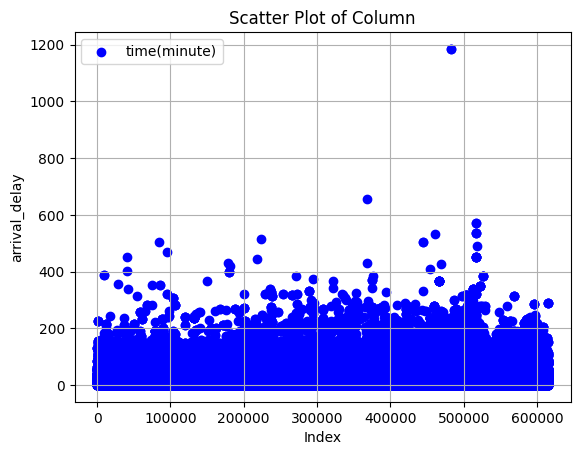

In [ ]:
# Vẽ đồ thị phân tán
plt.scatter(data_Arrival.index, data_Arrival["arrival_delay"], color='blue', label='time(minute)')

# Thêm nhãn và tiêu đề
plt.title('Scatter Plot of Column')
plt.xlabel('Index')
plt.ylabel('arrival_delay')
plt.legend()
plt.grid(True)

# Hiển thị đồ thị
plt.show()

### Gộp file Weather

In [ ]:
import pandas as pd

# Đường dẫn đến các tệp CSV
file_1_path = "drive/MyDrive/SVKT/newdata/VCA_Weather.csv"
file_2_path = "drive/MyDrive/SVKT/newdata/SGN_Weather.csv"
file_3_path = "drive/MyDrive/SVKT/newdata/PQC_Weather.csv"
file_4_path = "drive/MyDrive/SVKT/newdata/HAN_Weather.csv"
file_5_path = "drive/MyDrive/SVKT/newdata/HAH_Weather.csv"
file_6_path = "drive/MyDrive/SVKT/newdata/DAD_Weather.csv"

# Đọc từng tệp CSV thành DataFrame
df1 = pd.read_csv(file_1_path)
df2 = pd.read_csv(file_2_path)
df3 = pd.read_csv(file_3_path)
df4 = pd.read_csv(file_4_path)
df5 = pd.read_csv(file_5_path)
df6 = pd.read_csv(file_6_path)
# Gộp các DataFrame lại thành một
merged_df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)

# Lưu kết quả vào một tệp mới
output_path = "drive/MyDrive/SVKT/newdata/Weather_data.csv"
merged_df.to_csv(output_path, index=False)

print(f"Tệp đã được gộp thành công và lưu tại: {output_path}")

Tệp đã được gộp thành công và lưu tại: drive/MyDrive/SVKT/newdata/Weather_data.csv


## IV. CLEANING

Ở giai đoạn này, chúng em dọn dẹp thông tin đã thu thập được.

### DEPARTURE

#### 1.Đọc dữ liệu

In [ ]:
data_Departure.head(10)

,type,status,departure_iataCode,departure_icaoCode,departure_scheduledTime,departure_actualTime,departure_estimatedRunway,departure_actualRunway,arrival_iataCode,arrival_icaoCode,...,arrival_actualTime,arrival_estimatedRunway,arrival_actualRunway,arrival_delay,departure_estimatedTime,arrival_baggage,arrival_gate,error,departure_terminal,departure_gate
0,departure,active,vca,vvct,2023-11-01t10:00:00.000,2023-11-01t09:58:00.000,2023-11-01t09:58:00.000,2023-11-01t09:58:00.000,han,vvnb,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,departure,active,vca,vvct,2023-11-01t11:35:00.000,2023-11-01t11:41:00.000,2023-11-01t11:41:00.000,2023-11-01t11:41:00.000,dad,vvdn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,departure,active,vca,vvct,2023-11-01t11:35:00.000,2023-11-01t11:41:00.000,2023-11-01t11:41:00.000,2023-11-01t11:41:00.000,dad,vvdn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,departure,active,vca,vvct,2023-11-01t11:35:00.000,2023-11-01t11:41:00.000,2023-11-01t11:41:00.000,2023-11-01t11:41:00.000,dad,vvdn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,departure,active,vca,vvct,2023-11-01t11:35:00.000,2023-11-01t11:41:00.000,2023-11-01t11:41:00.000,2023-11-01t11:41:00.000,dad,vvdn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,departure,active,vca,vvct,2023-11-01t12:35:00.000,NaN,NaN,NaN,pqc,vvpq,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,departure,active,vca,vvct,2023-11-01t13:20:00.000,2023-11-01t13:14:00.000,2023-11-01t13:14:00.000,2023-11-01t13:14:00.000,dad,vvdn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,departure,active,vca,vvct,2023-11-01t14:15:00.000,2023-11-01t14:30:00.000,2023-11-01t14:30:00.000,2023-11-01t14:30:00.000,han,vvnb,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,departure,active,vca,vvct,2023-11-01t14:20:00.000,2023-11-01t14:19:00.000,2023-11-01t14:19:00.000,2023-11-01t14:19:00.000,vcs,vvcs,...,2023-11-01t14:53:00.000,2023-11-01t14:53:00.000,2023-11-01t14:53:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,departure,active,vca,vvct,2023-11-01t14:30:00.000,NaN,NaN,NaN,tpe,rctp,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_Departure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615592 entries, 0 to 615591
Data columns (total 36 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   type                          615586 non-null  object 
 1   status                        615586 non-null  object 
 2   departure_iataCode            615586 non-null  object 
 3   departure_icaoCode            615586 non-null  object 
 4   departure_scheduledTime       615586 non-null  object 
 5   departure_actualTime          439488 non-null  object 
 6   departure_estimatedRunway     439488 non-null  object 
 7   departure_actualRunway        439488 non-null  object 
 8   arrival_iataCode              615586 non-null  object 
 9   arrival_icaoCode              615586 non-null  object 
 10  arrival_terminal              424849 non-null  object 
 11  arrival_scheduledTime         615586 non-null  object 
 12  arrival_estimatedTime         430891 non-nul

#### 2.Lựa chọn các cột cần cho phân tích

In [ ]:
data_Departure_original = pd.DataFrame(data_Departure)

In [ ]:
columns_select = ["type","status","departure_iataCode","arrival_iataCode","departure_scheduledTime","departure_estimatedTime","departure_actualTime",
                  "departure_delay","arrival_scheduledTime","arrival_estimatedRunway","arrival_actualTime","arrival_delay","airline_name","airline_iataCode",
                  "flight_number","flight_iataNumber","codeshared_flight_icaoNumber"]

df_new_Departure = data_Departure_original[columns_select]
df_new_Departure.head(10)

,type,status,departure_iataCode,arrival_iataCode,departure_scheduledTime,departure_estimatedTime,departure_actualTime,departure_delay,arrival_scheduledTime,arrival_estimatedRunway,arrival_actualTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_flight_icaoNumber
0,departure,active,vca,han,2023-11-01t10:00:00.000,NaN,2023-11-01t09:58:00.000,NaN,2023-11-01t12:20:00.000,NaN,NaN,NaN,vietnam airlines,vn,1200.0,vn1200,NaN
1,departure,active,vca,dad,2023-11-01t11:35:00.000,NaN,2023-11-01t11:41:00.000,6.0,2023-11-01t13:05:00.000,NaN,NaN,NaN,NaN,a1,2702.0,a12702,vjc702
2,departure,active,vca,dad,2023-11-01t11:35:00.000,NaN,2023-11-01t11:41:00.000,6.0,2023-11-01t13:05:00.000,NaN,NaN,NaN,flexflight,w2,4702.0,w24702,vjc702
3,departure,active,vca,dad,2023-11-01t11:35:00.000,NaN,2023-11-01t11:41:00.000,6.0,2023-11-01t13:05:00.000,NaN,NaN,NaN,NaN,h1,4348.0,h14348,vjc702
4,departure,active,vca,dad,2023-11-01t11:35:00.000,NaN,2023-11-01t11:41:00.000,6.0,2023-11-01t13:05:00.000,NaN,NaN,NaN,vietjet air,vj,702.0,vj702,NaN
5,departure,active,vca,pqc,2023-11-01t12:35:00.000,NaN,NaN,NaN,2023-11-01t13:25:00.000,NaN,NaN,NaN,bamboo airways,qh,2181.0,qh2181,NaN
6,departure,active,vca,dad,2023-11-01t13:20:00.000,NaN,2023-11-01t13:14:00.000,NaN,2023-11-01t14:50:00.000,NaN,NaN,NaN,vietnam airlines,vn,1440.0,vn1440,NaN
7,departure,active,vca,han,2023-11-01t14:15:00.000,NaN,2023-11-01t14:30:00.000,16.0,2023-11-01t16:20:00.000,NaN,NaN,NaN,vietnam airlines,vn,1202.0,vn1202,NaN
8,departure,active,vca,vcs,2023-11-01t14:20:00.000,NaN,2023-11-01t14:19:00.000,NaN,2023-11-01t15:20:00.000,2023-11-01t14:53:00.000,2023-11-01t14:53:00.000,NaN,vasco,0v,8070.0,0v8070,NaN
9,departure,active,vca,tpe,2023-11-01t14:30:00.000,NaN,NaN,NaN,2023-11-01t18:55:00.000,NaN,NaN,NaN,NaN,h1,5181.0,h15181,vjc866


In [ ]:
df_new_Departure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615592 entries, 0 to 615591
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   type                          615586 non-null  object 
 1   status                        615586 non-null  object 
 2   departure_iataCode            615586 non-null  object 
 3   arrival_iataCode              615586 non-null  object 
 4   departure_scheduledTime       615586 non-null  object 
 5   departure_estimatedTime       475201 non-null  object 
 6   departure_actualTime          439488 non-null  object 
 7   departure_delay               460026 non-null  float64
 8   arrival_scheduledTime         615586 non-null  object 
 9   arrival_estimatedRunway       9907 non-null    object 
 10  arrival_actualTime            9907 non-null    object 
 11  arrival_delay                 107225 non-null  float64
 12  airline_name                  464249 non-nul

#### 3.Chuyển về kiểu thời gian chuẩn

In [ ]:
df_new_Departure["departure_scheduledTime"] = pd.to_datetime(df_new_Departure["departure_scheduledTime"])
df_new_Departure["arrival_scheduledTime"] = pd.to_datetime(df_new_Departure["arrival_scheduledTime"])
df_new_Departure["departure_estimatedTime"] = pd.to_datetime(df_new_Departure["departure_estimatedTime"])
df_new_Departure["departure_actualTime"] = pd.to_datetime(df_new_Departure["departure_actualTime"])
df_new_Departure["arrival_estimatedRunway"] = pd.to_datetime(df_new_Departure["arrival_estimatedRunway"])
df_new_Departure["arrival_actualTime"] = pd.to_datetime(df_new_Departure["arrival_actualTime"])

<ipython-input-86-07268641f1cc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_Departure["departure_scheduledTime"] = pd.to_datetime(df_new_Departure["departure_scheduledTime"])
<ipython-input-86-07268641f1cc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_Departure["arrival_scheduledTime"] = pd.to_datetime(df_new_Departure["arrival_scheduledTime"])
<ipython-input-86-07268641f1cc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

#### 4.Xóa các dòng là share plane

In [ ]:
df_new_Departure["codeshared_flight_icaoNumber"] = df_new_Departure["codeshared_flight_icaoNumber"].fillna("No_Share")

<ipython-input-87-4b1d69478c54>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_Departure["codeshared_flight_icaoNumber"] = df_new_Departure["codeshared_flight_icaoNumber"].fillna("No_Share")


In [ ]:
# Xác định các chỉ số của hàng cần xóa
rows_to_drop = df_new_Departure[df_new_Departure["codeshared_flight_icaoNumber"] != "No_Share"].index

# Xóa các hàng
df_new_Departure = df_new_Departure.drop(rows_to_drop)

df_new_Departure.head(10)

,type,status,departure_iataCode,arrival_iataCode,departure_scheduledTime,departure_estimatedTime,departure_actualTime,departure_delay,arrival_scheduledTime,arrival_estimatedRunway,arrival_actualTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_flight_icaoNumber
0,departure,active,vca,han,2023-11-01 10:00:00,NaT,2023-11-01 09:58:00,NaN,2023-11-01 12:20:00,NaT,NaT,NaN,vietnam airlines,vn,1200.0,vn1200,No_Share
4,departure,active,vca,dad,2023-11-01 11:35:00,NaT,2023-11-01 11:41:00,6.0,2023-11-01 13:05:00,NaT,NaT,NaN,vietjet air,vj,702.0,vj702,No_Share
5,departure,active,vca,pqc,2023-11-01 12:35:00,NaT,NaT,NaN,2023-11-01 13:25:00,NaT,NaT,NaN,bamboo airways,qh,2181.0,qh2181,No_Share
6,departure,active,vca,dad,2023-11-01 13:20:00,NaT,2023-11-01 13:14:00,NaN,2023-11-01 14:50:00,NaT,NaT,NaN,vietnam airlines,vn,1440.0,vn1440,No_Share
7,departure,active,vca,han,2023-11-01 14:15:00,NaT,2023-11-01 14:30:00,16.0,2023-11-01 16:20:00,NaT,NaT,NaN,vietnam airlines,vn,1202.0,vn1202,No_Share
8,departure,active,vca,vcs,2023-11-01 14:20:00,NaT,2023-11-01 14:19:00,NaN,2023-11-01 15:20:00,2023-11-01 14:53:00,2023-11-01 14:53:00,NaN,vasco,0v,8070.0,0v8070,No_Share
12,departure,active,vca,tpe,2023-11-01 14:30:00,NaT,NaT,NaN,2023-11-01 18:55:00,NaT,NaT,NaN,vietjet air,vj,866.0,vj866,No_Share
16,departure,active,vca,han,2023-11-01 15:50:00,NaT,NaT,NaN,2023-11-01 18:00:00,NaT,NaT,NaN,vietjet air,vj,468.0,vj468,No_Share
20,departure,active,vca,han,2023-11-01 18:30:00,NaT,2023-11-01 18:57:00,27.0,2023-11-01 20:40:00,NaT,NaT,12.0,vietjet air,vj,462.0,vj462,No_Share
21,departure,active,vca,han,2023-11-01 19:50:00,NaT,2023-11-01 19:54:00,5.0,2023-11-01 22:15:00,NaT,NaT,NaN,vietnam airlines,vn,1206.0,vn1206,No_Share


In [ ]:
df_new_Departure = df_new_Departure.reset_index(drop = True)
df_new_Departure.head()

,type,status,departure_iataCode,arrival_iataCode,departure_scheduledTime,departure_estimatedTime,departure_actualTime,departure_delay,arrival_scheduledTime,arrival_estimatedRunway,arrival_actualTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_flight_icaoNumber
0,departure,active,vca,han,2023-11-01 10:00:00,NaT,2023-11-01 09:58:00,NaN,2023-11-01 12:20:00,NaT,NaT,NaN,vietnam airlines,vn,1200.0,vn1200,No_Share
1,departure,active,vca,dad,2023-11-01 11:35:00,NaT,2023-11-01 11:41:00,6.0,2023-11-01 13:05:00,NaT,NaT,NaN,vietjet air,vj,702.0,vj702,No_Share
2,departure,active,vca,pqc,2023-11-01 12:35:00,NaT,NaT,NaN,2023-11-01 13:25:00,NaT,NaT,NaN,bamboo airways,qh,2181.0,qh2181,No_Share
3,departure,active,vca,dad,2023-11-01 13:20:00,NaT,2023-11-01 13:14:00,NaN,2023-11-01 14:50:00,NaT,NaT,NaN,vietnam airlines,vn,1440.0,vn1440,No_Share
4,departure,active,vca,han,2023-11-01 14:15:00,NaT,2023-11-01 14:30:00,16.0,2023-11-01 16:20:00,NaT,NaT,NaN,vietnam airlines,vn,1202.0,vn1202,No_Share


In [ ]:
#Xóa dòng unknown
drop_row = df_new_Departure[df_new_Departure['status'] == "unknown"].index

df_new_Departure = df_new_Departure.drop(drop_row)
df_new_Departure = df_new_Departure.reset_index(drop = True)

In [ ]:
# Tính toán thời gian chênh lệch
df_new_Departure['departure_delay'] = ((df_new_Departure['departure_actualTime'] - df_new_Departure['departure_scheduledTime']).dt.total_seconds() / 60) + 1

df_new_Departure['arrival_delay'] = ((df_new_Departure['arrival_actualTime'] - df_new_Departure['arrival_scheduledTime']).dt.total_seconds() / 60) + 1

In [ ]:
df_new_Departure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235887 entries, 0 to 235886
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   type                          235881 non-null  object        
 1   status                        235881 non-null  object        
 2   departure_iataCode            235881 non-null  object        
 3   arrival_iataCode              235881 non-null  object        
 4   departure_scheduledTime       235881 non-null  datetime64[ns]
 5   departure_estimatedTime       194130 non-null  datetime64[ns]
 6   departure_actualTime          185071 non-null  datetime64[ns]
 7   departure_delay               185071 non-null  float64       
 8   arrival_scheduledTime         235881 non-null  datetime64[ns]
 9   arrival_estimatedRunway       5977 non-null    datetime64[ns]
 10  arrival_actualTime            5977 non-null    datetime64[ns]
 11  arrival_delay

In [ ]:
df_new_Departure = df_new_Departure.dropna(subset=['departure_delay'])

In [ ]:
df_new_Departure.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185071 entries, 0 to 235885
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   type                          185071 non-null  object        
 1   status                        185071 non-null  object        
 2   departure_iataCode            185071 non-null  object        
 3   arrival_iataCode              185071 non-null  object        
 4   departure_scheduledTime       185071 non-null  datetime64[ns]
 5   departure_estimatedTime       154819 non-null  datetime64[ns]
 6   departure_actualTime          185071 non-null  datetime64[ns]
 7   departure_delay               185071 non-null  float64       
 8   arrival_scheduledTime         185071 non-null  datetime64[ns]
 9   arrival_estimatedRunway       5976 non-null    datetime64[ns]
 10  arrival_actualTime            5976 non-null    datetime64[ns]
 11  arrival_delay     

#### 5.Xóa giá trị ngoại lai

In [ ]:
# Tính tứ phân vị
Q1 = df_new_Departure['departure_delay'].quantile(0.25)  # Q1: Phân vị thứ nhất (25%)
Q2 = df_new_Departure['departure_delay'].quantile(0.50)  # Q2: Phân vị thứ hai (Median - Trung vị)
Q3 = df_new_Departure['departure_delay'].quantile(0.75)  # Q3: Phân vị thứ ba (75%)

# Tính IQR (Interquartile Range)
IQR = Q3 - Q1

# Khoảng hợp lệ để không bị coi là ngoại lai
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"{lower_bound},{upper_bound}")

-11.5,48.5


In [ ]:
# Loại bỏ giá trị ngoại lai
filtered_df_Departure = df_new_Departure[(df_new_Departure['departure_delay'] >= lower_bound) & (df_new_Departure['departure_delay'] <= upper_bound)]
filtered_df_Departure.reset_index(drop= True)

,type,status,departure_iataCode,arrival_iataCode,departure_scheduledTime,departure_estimatedTime,departure_actualTime,departure_delay,arrival_scheduledTime,arrival_estimatedRunway,arrival_actualTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_flight_icaoNumber
0,departure,active,vca,han,2023-11-01 10:00:00,NaT,2023-11-01 09:58:00,-1.0,2023-11-01 12:20:00,NaT,NaT,NaN,vietnam airlines,vn,1200.0,vn1200,No_Share
1,departure,active,vca,dad,2023-11-01 11:35:00,NaT,2023-11-01 11:41:00,7.0,2023-11-01 13:05:00,NaT,NaT,NaN,vietjet air,vj,702.0,vj702,No_Share
2,departure,active,vca,dad,2023-11-01 13:20:00,NaT,2023-11-01 13:14:00,-5.0,2023-11-01 14:50:00,NaT,NaT,NaN,vietnam airlines,vn,1440.0,vn1440,No_Share
3,departure,active,vca,han,2023-11-01 14:15:00,NaT,2023-11-01 14:30:00,16.0,2023-11-01 16:20:00,NaT,NaT,NaN,vietnam airlines,vn,1202.0,vn1202,No_Share
4,departure,active,vca,vcs,2023-11-01 14:20:00,NaT,2023-11-01 14:19:00,0.0,2023-11-01 15:20:00,2023-11-01 14:53:00,2023-11-01 14:53:00,-26.0,vasco,0v,8070.0,0v8070,No_Share
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180493,departure,active,dad,pus,2024-10-01 01:00:00,2024-10-01 01:00:00,2024-10-01 01:00:00,1.0,2024-10-01 07:30:00,NaT,NaT,NaN,air busan,bx,774.0,bx774,No_Share
180494,departure,active,dad,icn,2024-10-01 01:25:00,2024-10-01 01:48:00,2024-10-01 02:05:00,41.0,2024-10-01 08:00:00,NaT,NaT,NaN,jin air,lj,82.0,lj82,No_Share
180495,departure,active,dad,pus,2024-10-01 02:55:00,2024-10-01 02:43:00,2024-10-01 03:03:00,9.0,2024-10-01 09:00:00,NaT,NaT,NaN,vietjet air,vj,988.0,vj988,No_Share
180496,departure,active,dad,sgn,2024-10-01 06:05:00,2024-10-01 05:56:00,2024-10-01 06:15:00,11.0,2024-10-01 07:45:00,NaT,NaT,NaN,vietnam airlines,vn,105.0,vn105,No_Share


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


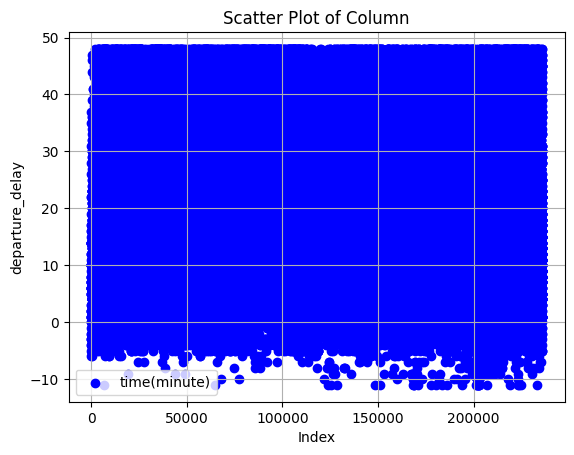

In [ ]:
# Vẽ đồ thị phân tán
plt.scatter(filtered_df_Departure.index, filtered_df_Departure["departure_delay"], color='blue', label='time(minute)')

# Thêm nhãn và tiêu đề
plt.title('Scatter Plot of Column')
plt.xlabel('Index')
plt.ylabel('departure_delay')
plt.legend()
plt.grid(True)

# Hiển thị đồ thị
plt.show()

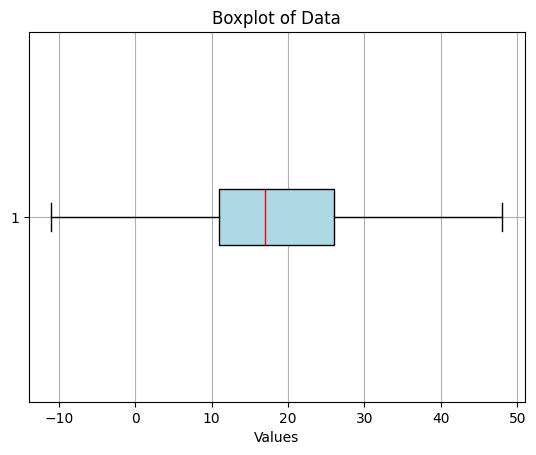

In [ ]:
# Vẽ boxplot
plt.boxplot(filtered_df_Departure['departure_delay'], vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))

# Thêm nhãn và tiêu đề
plt.title('Boxplot of Data')
plt.xlabel('Values')
plt.grid(True)

# Hiển thị đồ thị
plt.show()

#### 6.Ghép file thời tiết

In [ ]:
data_weather = pd.read_csv("drive/MyDrive/SVKT/newdata/Weather_data.csv")
data_weather.head(5)

,Unnamed: 0.1,Unnamed: 0,datetime (UTC),"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),relative_humidity (0-1),heating_degreeday (degC-Day),wind_speed (m/s),wind_direction (deg),total_cloud_cover (0-1),total_precipitation (mm of water equivalent),departure_itacode
0,0.0,0,2023-11-01 00:00:00,"(10.036422, 105.787522)",era5,1.66,7.0,27.08,25.59,0.92,0.0,1.89,356.28,0.12,0.00,vca
1,1.0,1,2023-11-01 01:00:00,"(10.036422, 105.787522)",era5,1.66,7.0,27.68,25.69,0.89,0.0,1.79,6.18,0.18,0.00,vca
2,2.0,2,2023-11-01 02:00:00,"(10.036422, 105.787522)",era5,1.66,7.0,29.80,25.78,0.79,0.0,1.82,33.79,0.15,0.08,vca
3,3.0,3,2023-11-01 03:00:00,"(10.036422, 105.787522)",era5,1.66,7.0,30.19,25.26,0.75,0.0,2.99,73.57,0.20,0.18,vca
4,4.0,4,2023-11-01 04:00:00,"(10.036422, 105.787522)",era5,1.66,7.0,30.55,25.47,0.74,0.0,3.70,83.65,0.42,0.06,vca


In [ ]:
# Chuyển đổi cột 'datetime (UTC)' sang định dạng datetime
data_weather['datetime (UTC)'] = pd.to_datetime(data_weather['datetime (UTC)'])

# Cộng thêm 7 giờ vào cột 'datetime (UTC)' để có giờ Việt Nam
data_weather['datetime (Vietnam)'] = data_weather['datetime (UTC)'] + pd.Timedelta(hours=7)

# Định dạng lại cột 'datetime (Vietnam)' theo kiểu '12/1/2023 8:20'
data_weather['datetime (Vietnam)'] = data_weather['datetime (Vietnam)'].dt.strftime('%-m/%-d/%Y %-H:%M')

#data_weather.head(5)


In [ ]:
# Cộng thêm 7 giờ vào cột 'datetime (UTC)' để có giờ Việt Nam
filtered_df_Departure['departure_scheduledTime'] = filtered_df_Departure['departure_scheduledTime']+ pd.Timedelta(hours=7)
filtered_df_Departure['departure_actualTime'] =filtered_df_Departure['departure_actualTime']+ pd.Timedelta(hours=7)
filtered_df_Departure['arrival_scheduledTime'] =filtered_df_Departure['arrival_scheduledTime']+ pd.Timedelta(hours=7)
filtered_df_Departure['arrival_estimatedRunway'] =filtered_df_Departure['arrival_estimatedRunway']+ pd.Timedelta(hours=7)
filtered_df_Departure['arrival_actualTime'] =filtered_df_Departure['arrival_actualTime']+ pd.Timedelta(hours=7)
# Định dạng lại cột 'datetime (Vietnam)' theo kiểu '12/1/2023 8:20'
filtered_df_Departure['departure_scheduledTime'] = filtered_df_Departure['departure_scheduledTime'].dt.strftime('%-m/%-d/%Y %-H:%M')
filtered_df_Departure['departure_actualTime'] =filtered_df_Departure['departure_actualTime'].dt.strftime('%-m/%-d/%Y %-H:%M')
filtered_df_Departure['arrival_scheduledTime'] =filtered_df_Departure['arrival_scheduledTime'].dt.strftime('%-m/%-d/%Y %-H:%M')
filtered_df_Departure['arrival_estimatedRunway'] =filtered_df_Departure['arrival_estimatedRunway'].dt.strftime('%-m/%-d/%Y %-H:%M')
filtered_df_Departure['arrival_actualTime'] =filtered_df_Departure['arrival_actualTime'].dt.strftime('%-m/%-d/%Y %-H:%M')
filtered_df_Departure.head(5)

<ipython-input-101-c70b03830199>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_Departure['departure_scheduledTime'] = filtered_df_Departure['departure_scheduledTime']+ pd.Timedelta(hours=7)
<ipython-input-101-c70b03830199>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_Departure['departure_actualTime'] =filtered_df_Departure['departure_actualTime']+ pd.Timedelta(hours=7)
<ipython-input-101-c70b03830199>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

,type,status,departure_iataCode,arrival_iataCode,departure_scheduledTime,departure_estimatedTime,departure_actualTime,departure_delay,arrival_scheduledTime,arrival_estimatedRunway,arrival_actualTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_flight_icaoNumber
0,departure,active,vca,han,11/1/2023 17:00,NaT,11/1/2023 16:58,-1.0,11/1/2023 19:20,NaN,NaN,NaN,vietnam airlines,vn,1200.0,vn1200,No_Share
1,departure,active,vca,dad,11/1/2023 18:35,NaT,11/1/2023 18:41,7.0,11/1/2023 20:05,NaN,NaN,NaN,vietjet air,vj,702.0,vj702,No_Share
3,departure,active,vca,dad,11/1/2023 20:20,NaT,11/1/2023 20:14,-5.0,11/1/2023 21:50,NaN,NaN,NaN,vietnam airlines,vn,1440.0,vn1440,No_Share
4,departure,active,vca,han,11/1/2023 21:15,NaT,11/1/2023 21:30,16.0,11/1/2023 23:20,NaN,NaN,NaN,vietnam airlines,vn,1202.0,vn1202,No_Share
5,departure,active,vca,vcs,11/1/2023 21:20,NaT,11/1/2023 21:19,0.0,11/1/2023 22:20,11/1/2023 21:53,11/1/2023 21:53,-26.0,vasco,0v,8070.0,0v8070,No_Share


In [ ]:
# Chuyển đổi các cột datetime sang định dạng datetime
data_weather['datetime (Vietnam)'] = pd.to_datetime(data_weather['datetime (Vietnam)'])
filtered_df_Departure['departure_scheduledTime'] = pd.to_datetime(filtered_df_Departure['departure_scheduledTime'])
filtered_df_Departure['arrival_scheduledTime'] = pd.to_datetime(filtered_df_Departure['arrival_scheduledTime'])

# Làm tròn thời gian trong filtered_df_Departure
filtered_df_Departure['rounded_datetime'] = filtered_df_Departure['departure_scheduledTime'].dt.floor('H')

# Loại bỏ các dòng trùng lặp trong data_weather
#data_weather = data_weather.drop_duplicates(subset=['datetime (Vietnam)'])

# Đổi tên cột ở DataFrame thứ hai để đồng nhất tên cột
data_weather.rename(columns={'datetime (Vietnam)': 'rounded_datetime'}, inplace=True)
data_weather.rename(columns={'departure_itacode': 'departure_iataCode'}, inplace=True)
# Merge dữ liệu với phương thức 'left'
merged_data = pd.merge(
    filtered_df_Departure,
    data_weather,
    on=['rounded_datetime','departure_iataCode'],
    how='left'
)

# Chọn các cột cần thiết cho output
output_columns = [
    'type', 'status', 'departure_iataCode', 'departure_scheduledTime', 'departure_actualTime',
    'departure_delay', 'arrival_iataCode', 'arrival_scheduledTime', 'arrival_actualTime', 'arrival_delay',
    'airline_name', 'airline_iataCode', 'flight_number', 'flight_iataNumber',
    'coordinates (lat,lon)', 'model (name)', 'model elevation (surface)',
    'utc_offset (hrs)', 'temperature (degC)', 'dewpoint_temperature (degC)',
    'relative_humidity (0-1)', 'heating_degreeday (degC-Day)',
    'wind_speed (m/s)', 'wind_direction (deg)', 'total_cloud_cover (0-1)',
    'total_precipitation (mm of water equivalent)'
]

# Tạo DataFrame cuối cùng với các cột đã chọn
final_data_Departure = merged_data[output_columns]
final_data_Departure.info()

<ipython-input-102-c0cba3c7809f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_Departure['departure_scheduledTime'] = pd.to_datetime(filtered_df_Departure['departure_scheduledTime'])
<ipython-input-102-c0cba3c7809f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_Departure['arrival_scheduledTime'] = pd.to_datetime(filtered_df_Departure['arrival_scheduledTime'])
<ipython-input-102-c0cba3c7809f>:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180498 entries, 0 to 180497
Data columns (total 26 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   type                                          180498 non-null  object        
 1   status                                        180498 non-null  object        
 2   departure_iataCode                            180498 non-null  object        
 3   departure_scheduledTime                       180498 non-null  datetime64[ns]
 4   departure_actualTime                          180498 non-null  object        
 5   departure_delay                               180498 non-null  float64       
 6   arrival_iataCode                              180498 non-null  object        
 7   arrival_scheduledTime                         180498 non-null  datetime64[ns]
 8   arrival_actualTime                            5579 non

In [ ]:
final_data_Departure.to_csv(f'drive/MyDrive/SVKT/newdata/final_data_Departure.csv', index=False)

### ARRIVAL

#### 1.Đọc dữ liệu

In [ ]:
data_Arrival.head(10)

,type,status,departure_iataCode,departure_icaoCode,departure_terminal,departure_delay,departure_scheduledTime,departure_actualTime,departure_estimatedRunway,departure_actualRunway,...,codeshared_flight_number,codeshared_flight_iataNumber,codeshared_flight_icaoNumber,arrival_delay,departure_estimatedTime,departure_gate,error,arrival_terminal,arrival_gate,arrival_baggage
0,arrival,landed,han,vvnb,t1,13.0,2023-11-01t06:35:00.000,2023-11-01t06:48:00.000,2023-11-01t06:48:00.000,2023-11-01t06:48:00.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,arrival,unknown,vii,vvvh,NaN,NaN,2023-11-01t08:50:00.000,NaN,NaN,NaN,...,481.0,vj481,vjc481,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,arrival,unknown,vii,vvvh,NaN,NaN,2023-11-01t08:50:00.000,NaN,NaN,NaN,...,481.0,vj481,vjc481,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,arrival,unknown,vii,vvvh,NaN,NaN,2023-11-01t08:50:00.000,NaN,NaN,NaN,...,481.0,vj481,vjc481,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,arrival,unknown,vii,vvvh,NaN,NaN,2023-11-01t08:50:00.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,arrival,landed,han,vvnb,t1,11.0,2023-11-01t08:45:00.000,2023-11-01t08:55:00.000,2023-11-01t08:55:00.000,2023-11-01t08:55:00.000,...,461.0,vj461,vjc461,2.0,NaN,NaN,NaN,NaN,NaN,NaN
6,arrival,landed,han,vvnb,t1,11.0,2023-11-01t08:45:00.000,2023-11-01t08:55:00.000,2023-11-01t08:55:00.000,2023-11-01t08:55:00.000,...,461.0,vj461,vjc461,2.0,NaN,NaN,NaN,NaN,NaN,NaN
7,arrival,landed,han,vvnb,t1,11.0,2023-11-01t08:45:00.000,2023-11-01t08:55:00.000,2023-11-01t08:55:00.000,2023-11-01t08:55:00.000,...,461.0,vj461,vjc461,2.0,NaN,NaN,NaN,NaN,NaN,NaN
8,arrival,landed,han,vvnb,t1,11.0,2023-11-01t08:45:00.000,2023-11-01t08:55:00.000,2023-11-01t08:55:00.000,2023-11-01t08:55:00.000,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
9,arrival,unknown,pqc,vvpq,NaN,NaN,2023-11-01t11:10:00.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_Arrival.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614975 entries, 0 to 614974
Data columns (total 36 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   type                          614969 non-null  object 
 1   status                        614969 non-null  object 
 2   departure_iataCode            614755 non-null  object 
 3   departure_icaoCode            614756 non-null  object 
 4   departure_terminal            423700 non-null  object 
 5   departure_delay               516270 non-null  float64
 6   departure_scheduledTime       614969 non-null  object 
 7   departure_actualTime          540773 non-null  object 
 8   departure_estimatedRunway     540773 non-null  object 
 9   departure_actualRunway        540773 non-null  object 
 10  arrival_iataCode              614969 non-null  object 
 11  arrival_icaoCode              614969 non-null  object 
 12  arrival_scheduledTime         614969 non-nul

#### 2.Lựa chọn các cột cần cho phân tích

In [ ]:
data_Arrival_original = pd.DataFrame(data_Arrival)
data_Arrival_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614975 entries, 0 to 614974
Data columns (total 36 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   type                          614969 non-null  object 
 1   status                        614969 non-null  object 
 2   departure_iataCode            614755 non-null  object 
 3   departure_icaoCode            614756 non-null  object 
 4   departure_terminal            423700 non-null  object 
 5   departure_delay               516270 non-null  float64
 6   departure_scheduledTime       614969 non-null  object 
 7   departure_actualTime          540773 non-null  object 
 8   departure_estimatedRunway     540773 non-null  object 
 9   departure_actualRunway        540773 non-null  object 
 10  arrival_iataCode              614969 non-null  object 
 11  arrival_icaoCode              614969 non-null  object 
 12  arrival_scheduledTime         614969 non-nul

In [ ]:
columns_select = ["type","status","departure_iataCode","arrival_iataCode","departure_scheduledTime","departure_estimatedTime","departure_actualTime",
                  "departure_delay","arrival_scheduledTime","arrival_estimatedRunway","arrival_actualTime","arrival_delay","airline_name","airline_iataCode",
                  "flight_number","flight_iataNumber","codeshared_flight_icaoNumber"]

df_new_Arrival = data_Arrival_original[columns_select]
df_new_Arrival.head(10)

,type,status,departure_iataCode,arrival_iataCode,departure_scheduledTime,departure_estimatedTime,departure_actualTime,departure_delay,arrival_scheduledTime,arrival_estimatedRunway,arrival_actualTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_flight_icaoNumber
0,arrival,landed,han,vca,2023-11-01t06:35:00.000,NaN,2023-11-01t06:48:00.000,13.0,2023-11-01t08:55:00.000,2023-11-01t08:41:00.000,2023-11-01t08:41:00.000,NaN,vietnam airlines,vn,1201.0,vn1201,NaN
1,arrival,unknown,vii,vca,2023-11-01t08:50:00.000,NaN,NaN,NaN,2023-11-01t10:40:00.000,NaN,NaN,NaN,NaN,a1,2481.0,a12481,vjc481
2,arrival,unknown,vii,vca,2023-11-01t08:50:00.000,NaN,NaN,NaN,2023-11-01t10:40:00.000,NaN,NaN,NaN,flexflight,w2,4481.0,w24481,vjc481
3,arrival,unknown,vii,vca,2023-11-01t08:50:00.000,NaN,NaN,NaN,2023-11-01t10:40:00.000,NaN,NaN,NaN,NaN,h1,4333.0,h14333,vjc481
4,arrival,unknown,vii,vca,2023-11-01t08:50:00.000,NaN,NaN,NaN,2023-11-01t10:40:00.000,NaN,NaN,NaN,vietjet air,vj,481.0,vj481,NaN
5,arrival,landed,han,vca,2023-11-01t08:45:00.000,NaN,2023-11-01t08:55:00.000,11.0,2023-11-01t10:50:00.000,2023-11-01t10:51:00.000,2023-11-01t10:51:00.000,2.0,NaN,a1,2461.0,a12461,vjc461
6,arrival,landed,han,vca,2023-11-01t08:45:00.000,NaN,2023-11-01t08:55:00.000,11.0,2023-11-01t10:50:00.000,2023-11-01t10:51:00.000,2023-11-01t10:51:00.000,2.0,flexflight,w2,4461.0,w24461,vjc461
7,arrival,landed,han,vca,2023-11-01t08:45:00.000,NaN,2023-11-01t08:55:00.000,11.0,2023-11-01t10:50:00.000,2023-11-01t10:51:00.000,2023-11-01t10:51:00.000,2.0,NaN,h1,4331.0,h14331,vjc461
8,arrival,landed,han,vca,2023-11-01t08:45:00.000,NaN,2023-11-01t08:55:00.000,11.0,2023-11-01t10:50:00.000,2023-11-01t10:51:00.000,2023-11-01t10:51:00.000,2.0,vietjet air,vj,461.0,vj461,NaN
9,arrival,unknown,pqc,vca,2023-11-01t11:10:00.000,NaN,NaN,NaN,2023-11-01t12:00:00.000,NaN,NaN,NaN,bamboo airways,qh,2182.0,qh2182,NaN


In [ ]:
df_new_Arrival.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614975 entries, 0 to 614974
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   type                          614969 non-null  object 
 1   status                        614969 non-null  object 
 2   departure_iataCode            614755 non-null  object 
 3   arrival_iataCode              614969 non-null  object 
 4   departure_scheduledTime       614969 non-null  object 
 5   departure_estimatedTime       422364 non-null  object 
 6   departure_actualTime          540773 non-null  object 
 7   departure_delay               516270 non-null  float64
 8   arrival_scheduledTime         614969 non-null  object 
 9   arrival_estimatedRunway       485190 non-null  object 
 10  arrival_actualTime            485190 non-null  object 
 11  arrival_delay                 235963 non-null  float64
 12  airline_name                  465546 non-nul

#### 3.Chuyển về kiểu thời gian chuẩn

In [ ]:
df_new_Arrival["departure_scheduledTime"] = pd.to_datetime(df_new_Arrival["departure_scheduledTime"])
df_new_Arrival["arrival_scheduledTime"] = pd.to_datetime(df_new_Arrival["arrival_scheduledTime"])
df_new_Arrival["departure_estimatedTime"] = pd.to_datetime(df_new_Arrival["departure_estimatedTime"])
df_new_Arrival["departure_actualTime"] = pd.to_datetime(df_new_Arrival["departure_actualTime"])
df_new_Arrival["arrival_estimatedRunway"] = pd.to_datetime(df_new_Arrival["arrival_estimatedRunway"])
df_new_Arrival["arrival_actualTime"] = pd.to_datetime(df_new_Arrival["arrival_actualTime"])

<ipython-input-46-7a4286fd03b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_Arrival["departure_scheduledTime"] = pd.to_datetime(df_new_Arrival["departure_scheduledTime"])
<ipython-input-46-7a4286fd03b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_Arrival["arrival_scheduledTime"] = pd.to_datetime(df_new_Arrival["arrival_scheduledTime"])
<ipython-input-46-7a4286fd03b7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

#### 4.Xóa các dòng là share plane

In [ ]:
df_new_Arrival["codeshared_flight_icaoNumber"] = df_new_Arrival["codeshared_flight_icaoNumber"].fillna("No_Share")

<ipython-input-47-a24046be3d97>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_Arrival["codeshared_flight_icaoNumber"] = df_new_Arrival["codeshared_flight_icaoNumber"].fillna("No_Share")


In [ ]:
# Xác định các chỉ số của hàng cần xóa
rows_to_drop = df_new_Arrival[df_new_Arrival["codeshared_flight_icaoNumber"] != "No_Share"].index

# Xóa các hàng
df_new_Arrival = df_new_Arrival.drop(rows_to_drop)

df_new_Arrival.head(10)

,type,status,departure_iataCode,arrival_iataCode,departure_scheduledTime,departure_estimatedTime,departure_actualTime,departure_delay,arrival_scheduledTime,arrival_estimatedRunway,arrival_actualTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_flight_icaoNumber
0,arrival,landed,han,vca,2023-11-01 06:35:00,NaT,2023-11-01 06:48:00,13.0,2023-11-01 08:55:00,2023-11-01 08:41:00,2023-11-01 08:41:00,NaN,vietnam airlines,vn,1201.0,vn1201,No_Share
4,arrival,unknown,vii,vca,2023-11-01 08:50:00,NaT,NaT,NaN,2023-11-01 10:40:00,NaT,NaT,NaN,vietjet air,vj,481.0,vj481,No_Share
8,arrival,landed,han,vca,2023-11-01 08:45:00,NaT,2023-11-01 08:55:00,11.0,2023-11-01 10:50:00,2023-11-01 10:51:00,2023-11-01 10:51:00,2.0,vietjet air,vj,461.0,vj461,No_Share
9,arrival,unknown,pqc,vca,2023-11-01 11:10:00,NaT,NaT,NaN,2023-11-01 12:00:00,NaT,NaT,NaN,bamboo airways,qh,2182.0,qh2182,No_Share
10,arrival,landed,dad,vca,2023-11-01 11:00:00,NaT,2023-11-01 11:01:00,1.0,2023-11-01 12:40:00,2023-11-01 12:13:00,2023-11-01 12:13:00,NaN,vietnam airlines,vn,1441.0,vn1441,No_Share
11,arrival,landed,han,vca,2023-11-01 11:15:00,2023-11-01 11:12:00,2023-11-01 11:30:00,15.0,2023-11-01 13:30:00,2023-11-01 13:20:00,2023-11-01 13:20:00,NaN,vietnam airlines,vn,1203.0,vn1203,No_Share
12,arrival,landed,vcs,vca,2023-11-01 12:50:00,NaT,2023-11-01 12:45:00,NaN,2023-11-01 13:50:00,2023-11-01 13:30:00,2023-11-01 13:30:00,NaN,vasco,0v,8071.0,0v8071,No_Share
16,arrival,landed,dad,vca,2023-11-01 13:45:00,NaT,2023-11-01 13:54:00,9.0,2023-11-01 15:15:00,2023-11-01 15:07:00,2023-11-01 15:07:00,NaN,vietjet air,vj,703.0,vj703,No_Share
20,arrival,landed,han,vca,2023-11-01 15:45:00,NaT,2023-11-01 15:59:00,15.0,2023-11-01 17:55:00,2023-11-01 17:50:00,2023-11-01 17:50:00,NaN,vietjet air,vj,463.0,vj463,No_Share
21,arrival,landed,han,vca,2023-11-01 16:45:00,2023-11-01 16:41:00,2023-11-01 16:57:00,13.0,2023-11-01 19:05:00,2023-11-01 18:50:00,2023-11-01 18:50:00,NaN,vietnam airlines,vn,1207.0,vn1207,No_Share


In [ ]:
df_new_Arrival = df_new_Arrival.reset_index(drop = True)
df_new_Arrival.head()

,type,status,departure_iataCode,arrival_iataCode,departure_scheduledTime,departure_estimatedTime,departure_actualTime,departure_delay,arrival_scheduledTime,arrival_estimatedRunway,arrival_actualTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_flight_icaoNumber
0,arrival,landed,han,vca,2023-11-01 06:35:00,NaT,2023-11-01 06:48:00,13.0,2023-11-01 08:55:00,2023-11-01 08:41:00,2023-11-01 08:41:00,NaN,vietnam airlines,vn,1201.0,vn1201,No_Share
1,arrival,unknown,vii,vca,2023-11-01 08:50:00,NaT,NaT,NaN,2023-11-01 10:40:00,NaT,NaT,NaN,vietjet air,vj,481.0,vj481,No_Share
2,arrival,landed,han,vca,2023-11-01 08:45:00,NaT,2023-11-01 08:55:00,11.0,2023-11-01 10:50:00,2023-11-01 10:51:00,2023-11-01 10:51:00,2.0,vietjet air,vj,461.0,vj461,No_Share
3,arrival,unknown,pqc,vca,2023-11-01 11:10:00,NaT,NaT,NaN,2023-11-01 12:00:00,NaT,NaT,NaN,bamboo airways,qh,2182.0,qh2182,No_Share
4,arrival,landed,dad,vca,2023-11-01 11:00:00,NaT,2023-11-01 11:01:00,1.0,2023-11-01 12:40:00,2023-11-01 12:13:00,2023-11-01 12:13:00,NaN,vietnam airlines,vn,1441.0,vn1441,No_Share


In [ ]:
#Xóa dòng unknown
drop_row = df_new_Arrival[df_new_Arrival['status'] == "unknown"].index

df_new_Arrival = df_new_Arrival.drop(drop_row)
df_new_Arrival = df_new_Arrival.reset_index(drop = True)

In [ ]:
# Tính toán thời gian chênh lệch
df_new_Arrival['departure_delay'] = ((df_new_Arrival['departure_actualTime'] - df_new_Arrival['departure_scheduledTime']).dt.total_seconds() / 60) + 1

df_new_Arrival['arrival_delay'] = ((df_new_Arrival['arrival_actualTime'] - df_new_Arrival['arrival_scheduledTime']).dt.total_seconds() / 60) + 1

In [ ]:
df_new_Arrival.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224305 entries, 0 to 224304
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   type                          224299 non-null  object        
 1   status                        224299 non-null  object        
 2   departure_iataCode            224290 non-null  object        
 3   arrival_iataCode              224299 non-null  object        
 4   departure_scheduledTime       224299 non-null  datetime64[ns]
 5   departure_estimatedTime       159234 non-null  datetime64[ns]
 6   departure_actualTime          221393 non-null  datetime64[ns]
 7   departure_delay               221393 non-null  float64       
 8   arrival_scheduledTime         224299 non-null  datetime64[ns]
 9   arrival_estimatedRunway       203108 non-null  datetime64[ns]
 10  arrival_actualTime            203108 non-null  datetime64[ns]
 11  arrival_delay

In [ ]:
df_new_Arrival = df_new_Arrival.dropna(subset=['arrival_delay'])

In [ ]:
df_new_Arrival.head(10)

,type,status,departure_iataCode,arrival_iataCode,departure_scheduledTime,departure_estimatedTime,departure_actualTime,departure_delay,arrival_scheduledTime,arrival_estimatedRunway,arrival_actualTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_flight_icaoNumber
0,arrival,landed,han,vca,2023-11-01 06:35:00,NaT,2023-11-01 06:48:00,14.0,2023-11-01 08:55:00,2023-11-01 08:41:00,2023-11-01 08:41:00,-13.0,vietnam airlines,vn,1201.0,vn1201,No_Share
1,arrival,landed,han,vca,2023-11-01 08:45:00,NaT,2023-11-01 08:55:00,11.0,2023-11-01 10:50:00,2023-11-01 10:51:00,2023-11-01 10:51:00,2.0,vietjet air,vj,461.0,vj461,No_Share
2,arrival,landed,dad,vca,2023-11-01 11:00:00,NaT,2023-11-01 11:01:00,2.0,2023-11-01 12:40:00,2023-11-01 12:13:00,2023-11-01 12:13:00,-26.0,vietnam airlines,vn,1441.0,vn1441,No_Share
3,arrival,landed,han,vca,2023-11-01 11:15:00,2023-11-01 11:12:00,2023-11-01 11:30:00,16.0,2023-11-01 13:30:00,2023-11-01 13:20:00,2023-11-01 13:20:00,-9.0,vietnam airlines,vn,1203.0,vn1203,No_Share
4,arrival,landed,vcs,vca,2023-11-01 12:50:00,NaT,2023-11-01 12:45:00,-4.0,2023-11-01 13:50:00,2023-11-01 13:30:00,2023-11-01 13:30:00,-19.0,vasco,0v,8071.0,0v8071,No_Share
5,arrival,landed,dad,vca,2023-11-01 13:45:00,NaT,2023-11-01 13:54:00,10.0,2023-11-01 15:15:00,2023-11-01 15:07:00,2023-11-01 15:07:00,-7.0,vietjet air,vj,703.0,vj703,No_Share
6,arrival,landed,han,vca,2023-11-01 15:45:00,NaT,2023-11-01 15:59:00,15.0,2023-11-01 17:55:00,2023-11-01 17:50:00,2023-11-01 17:50:00,-4.0,vietjet air,vj,463.0,vj463,No_Share
7,arrival,landed,han,vca,2023-11-01 16:45:00,2023-11-01 16:41:00,2023-11-01 16:57:00,13.0,2023-11-01 19:05:00,2023-11-01 18:50:00,2023-11-01 18:50:00,-14.0,vietnam airlines,vn,1207.0,vn1207,No_Share
8,arrival,landed,han,vca,2023-11-01 19:05:00,2023-11-01 18:58:00,2023-11-01 19:08:00,4.0,2023-11-01 21:10:00,2023-11-01 20:58:00,2023-11-01 20:58:00,-11.0,vietjet air,vj,467.0,vj467,No_Share
9,arrival,landed,vii,vca,2023-11-01 08:50:00,2023-11-01 13:58:00,2023-11-01 13:58:00,309.0,2023-11-01 15:50:00,2023-11-01 15:32:00,2023-11-01 15:32:00,-17.0,vietjet air,vj,481.0,vj481,No_Share


#### 5.Xóa giá trị ngoại lai

In [ ]:
# Tính tứ phân vị
Q1 = df_new_Arrival['arrival_delay'].quantile(0.25)  # Q1: Phân vị thứ nhất (25%)
Q2 = df_new_Arrival['arrival_delay'].quantile(0.50)  # Q2: Phân vị thứ hai (Median - Trung vị)
Q3 = df_new_Arrival['arrival_delay'].quantile(0.75)  # Q3: Phân vị thứ ba (75%)

# Tính IQR (Interquartile Range)
IQR = Q3 - Q1

# Khoảng hợp lệ để không bị coi là ngoại lai
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"{lower_bound},{upper_bound}")

-55.5,44.5


In [ ]:
# Loại bỏ giá trị ngoại lai
filtered_df_Arrival = df_new_Arrival[(df_new_Arrival['arrival_delay'] >= lower_bound) & (df_new_Arrival['arrival_delay'] <= upper_bound)]
filtered_df_Arrival.reset_index(drop= True)

,type,status,departure_iataCode,arrival_iataCode,departure_scheduledTime,departure_estimatedTime,departure_actualTime,departure_delay,arrival_scheduledTime,arrival_estimatedRunway,arrival_actualTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_flight_icaoNumber
0,arrival,landed,han,vca,2023-11-01 06:35:00,NaT,2023-11-01 06:48:00,14.0,2023-11-01 08:55:00,2023-11-01 08:41:00,2023-11-01 08:41:00,-13.0,vietnam airlines,vn,1201.0,vn1201,No_Share
1,arrival,landed,han,vca,2023-11-01 08:45:00,NaT,2023-11-01 08:55:00,11.0,2023-11-01 10:50:00,2023-11-01 10:51:00,2023-11-01 10:51:00,2.0,vietjet air,vj,461.0,vj461,No_Share
2,arrival,landed,dad,vca,2023-11-01 11:00:00,NaT,2023-11-01 11:01:00,2.0,2023-11-01 12:40:00,2023-11-01 12:13:00,2023-11-01 12:13:00,-26.0,vietnam airlines,vn,1441.0,vn1441,No_Share
3,arrival,landed,han,vca,2023-11-01 11:15:00,2023-11-01 11:12:00,2023-11-01 11:30:00,16.0,2023-11-01 13:30:00,2023-11-01 13:20:00,2023-11-01 13:20:00,-9.0,vietnam airlines,vn,1203.0,vn1203,No_Share
4,arrival,landed,vcs,vca,2023-11-01 12:50:00,NaT,2023-11-01 12:45:00,-4.0,2023-11-01 13:50:00,2023-11-01 13:30:00,2023-11-01 13:30:00,-19.0,vasco,0v,8071.0,0v8071,No_Share
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198588,arrival,landed,pus,dad,2024-09-30 21:55:00,2024-09-30 21:55:00,2024-09-30 22:44:00,50.0,2024-10-01 00:25:00,2024-10-01 00:38:00,2024-10-01 00:38:00,14.0,jin air,lj,111.0,lj111,No_Share
198589,arrival,landed,icn,dad,2024-09-30 21:35:00,2024-09-30 21:55:00,2024-09-30 22:12:00,38.0,2024-10-01 00:25:00,2024-10-01 00:12:00,2024-10-01 00:12:00,-12.0,t'way air,tw,127.0,tw127,No_Share
198590,arrival,landed,icn,dad,2024-09-30 21:55:00,2024-09-30 22:07:00,2024-09-30 22:21:00,27.0,2024-10-01 00:30:00,2024-10-01 00:23:00,2024-10-01 00:23:00,-6.0,jeju air,7c,2903.0,7c2903,No_Share
198591,arrival,landed,icn,dad,2024-09-30 22:45:00,2024-09-30 23:05:00,2024-09-30 23:32:00,48.0,2024-10-01 01:25:00,2024-10-01 01:33:00,2024-10-01 01:33:00,9.0,vietjet air,vj,875.0,vj875,No_Share


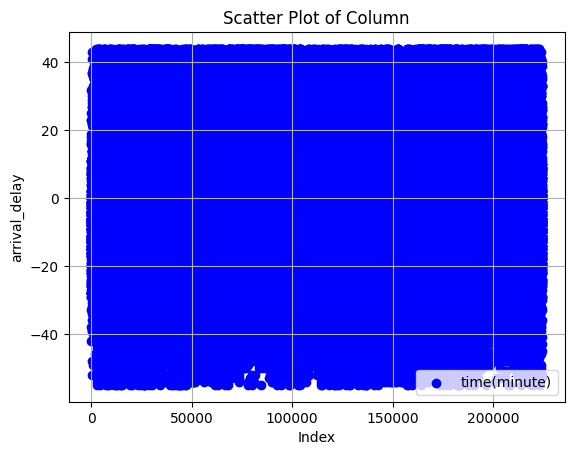

In [ ]:
# Vẽ đồ thị phân tán
plt.scatter(filtered_df_Arrival.index, filtered_df_Arrival["arrival_delay"], color='blue', label='time(minute)')

# Thêm nhãn và tiêu đề
plt.title('Scatter Plot of Column')
plt.xlabel('Index')
plt.ylabel('arrival_delay')
plt.legend()
plt.grid(True)

# Hiển thị đồ thị
plt.show()

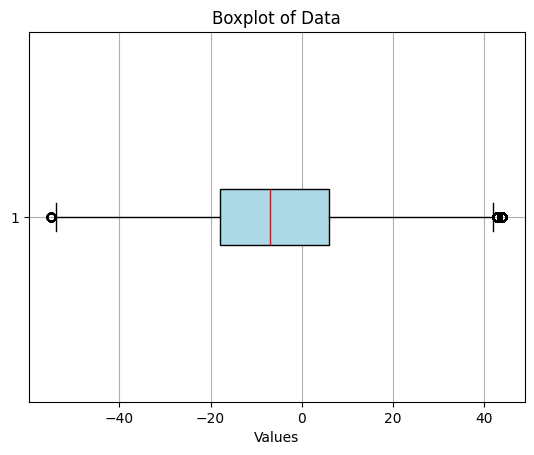

In [ ]:
# Vẽ boxplot
plt.boxplot(filtered_df_Arrival['arrival_delay'], vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))

# Thêm nhãn và tiêu đề
plt.title('Boxplot of Data')
plt.xlabel('Values')
plt.grid(True)

# Hiển thị đồ thị
plt.show()

#### 6.Ghép file thời tiết

In [ ]:
filtered_df_Arrival['departure_scheduledTime'] = filtered_df_Arrival['departure_scheduledTime']+ pd.Timedelta(hours=7)
filtered_df_Arrival['departure_actualTime'] =filtered_df_Arrival['departure_actualTime']+ pd.Timedelta(hours=7)
filtered_df_Arrival['arrival_scheduledTime'] =filtered_df_Arrival['arrival_scheduledTime']+ pd.Timedelta(hours=7)
filtered_df_Arrival['arrival_estimatedRunway'] =filtered_df_Arrival['arrival_estimatedRunway']+ pd.Timedelta(hours=7)
filtered_df_Arrival['arrival_actualTime'] =filtered_df_Arrival['arrival_actualTime']+ pd.Timedelta(hours=7)
filtered_df_Arrival['departure_scheduledTime'] = filtered_df_Arrival['departure_scheduledTime'].dt.strftime('%-m/%-d/%Y %-H:%M')
filtered_df_Arrival['departure_actualTime'] =filtered_df_Arrival['departure_actualTime'].dt.strftime('%-m/%-d/%Y %-H:%M')
filtered_df_Arrival['arrival_scheduledTime'] =filtered_df_Arrival['arrival_scheduledTime'].dt.strftime('%-m/%-d/%Y %-H:%M')
filtered_df_Arrival['arrival_estimatedRunway'] =filtered_df_Arrival['arrival_estimatedRunway'].dt.strftime('%-m/%-d/%Y %-H:%M')
filtered_df_Arrival['arrival_actualTime'] =filtered_df_Arrival['arrival_actualTime'].dt.strftime('%-m/%-d/%Y %-H:%M')
filtered_df_Arrival.head(5)

<ipython-input-59-8f160fdfbdd3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_Arrival['departure_scheduledTime'] = filtered_df_Arrival['departure_scheduledTime']+ pd.Timedelta(hours=7)
<ipython-input-59-8f160fdfbdd3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_Arrival['departure_actualTime'] =filtered_df_Arrival['departure_actualTime']+ pd.Timedelta(hours=7)
<ipython-input-59-8f160fdfbdd3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

,type,status,departure_iataCode,arrival_iataCode,departure_scheduledTime,departure_estimatedTime,departure_actualTime,departure_delay,arrival_scheduledTime,arrival_estimatedRunway,arrival_actualTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_flight_icaoNumber
0,arrival,landed,han,vca,11/1/2023 13:35,NaT,11/1/2023 13:48,14.0,11/1/2023 15:55,11/1/2023 15:41,11/1/2023 15:41,-13.0,vietnam airlines,vn,1201.0,vn1201,No_Share
1,arrival,landed,han,vca,11/1/2023 15:45,NaT,11/1/2023 15:55,11.0,11/1/2023 17:50,11/1/2023 17:51,11/1/2023 17:51,2.0,vietjet air,vj,461.0,vj461,No_Share
2,arrival,landed,dad,vca,11/1/2023 18:00,NaT,11/1/2023 18:01,2.0,11/1/2023 19:40,11/1/2023 19:13,11/1/2023 19:13,-26.0,vietnam airlines,vn,1441.0,vn1441,No_Share
3,arrival,landed,han,vca,11/1/2023 18:15,2023-11-01 11:12:00,11/1/2023 18:30,16.0,11/1/2023 20:30,11/1/2023 20:20,11/1/2023 20:20,-9.0,vietnam airlines,vn,1203.0,vn1203,No_Share
4,arrival,landed,vcs,vca,11/1/2023 19:50,NaT,11/1/2023 19:45,-4.0,11/1/2023 20:50,11/1/2023 20:30,11/1/2023 20:30,-19.0,vasco,0v,8071.0,0v8071,No_Share


In [ ]:
data_weather = pd.read_csv("drive/MyDrive/SVKT/newdata/Weather_data.csv")
data_weather.head(5)

,Unnamed: 0.1,Unnamed: 0,datetime (UTC),"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),relative_humidity (0-1),heating_degreeday (degC-Day),wind_speed (m/s),wind_direction (deg),total_cloud_cover (0-1),total_precipitation (mm of water equivalent),departure_itacode
0,0.0,0,2023-11-01 00:00:00,"(10.036422, 105.787522)",era5,1.66,7.0,27.08,25.59,0.92,0.0,1.89,356.28,0.12,0.00,vca
1,1.0,1,2023-11-01 01:00:00,"(10.036422, 105.787522)",era5,1.66,7.0,27.68,25.69,0.89,0.0,1.79,6.18,0.18,0.00,vca
2,2.0,2,2023-11-01 02:00:00,"(10.036422, 105.787522)",era5,1.66,7.0,29.80,25.78,0.79,0.0,1.82,33.79,0.15,0.08,vca
3,3.0,3,2023-11-01 03:00:00,"(10.036422, 105.787522)",era5,1.66,7.0,30.19,25.26,0.75,0.0,2.99,73.57,0.20,0.18,vca
4,4.0,4,2023-11-01 04:00:00,"(10.036422, 105.787522)",era5,1.66,7.0,30.55,25.47,0.74,0.0,3.70,83.65,0.42,0.06,vca


In [ ]:
# Chuyển đổi cột 'datetime (UTC)' sang định dạng datetime
data_weather['datetime (UTC)'] = pd.to_datetime(data_weather['datetime (UTC)'])

# Cộng thêm 7 giờ vào cột 'datetime (UTC)' để có giờ Việt Nam
data_weather['datetime (Vietnam)'] = data_weather['datetime (UTC)'] + pd.Timedelta(hours=7)

# Định dạng lại cột 'datetime (Vietnam)' theo kiểu '12/1/2023 8:20'
data_weather['datetime (Vietnam)'] = data_weather['datetime (Vietnam)'].dt.strftime('%-m/%-d/%Y %-H:%M')

#data_weather.head(5)


In [ ]:
data_weather.head(10)

,Unnamed: 0.1,Unnamed: 0,datetime (UTC),"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),relative_humidity (0-1),heating_degreeday (degC-Day),wind_speed (m/s),wind_direction (deg),total_cloud_cover (0-1),total_precipitation (mm of water equivalent),departure_itacode,datetime (Vietnam)
0,0.0,0,2023-11-01 00:00:00,"(10.036422, 105.787522)",era5,1.66,7.0,27.08,25.59,0.92,0.0,1.89,356.28,0.12,0.00,vca,11/1/2023 7:00
1,1.0,1,2023-11-01 01:00:00,"(10.036422, 105.787522)",era5,1.66,7.0,27.68,25.69,0.89,0.0,1.79,6.18,0.18,0.00,vca,11/1/2023 8:00
2,2.0,2,2023-11-01 02:00:00,"(10.036422, 105.787522)",era5,1.66,7.0,29.80,25.78,0.79,0.0,1.82,33.79,0.15,0.08,vca,11/1/2023 9:00
3,3.0,3,2023-11-01 03:00:00,"(10.036422, 105.787522)",era5,1.66,7.0,30.19,25.26,0.75,0.0,2.99,73.57,0.20,0.18,vca,11/1/2023 10:00
4,4.0,4,2023-11-01 04:00:00,"(10.036422, 105.787522)",era5,1.66,7.0,30.55,25.47,0.74,0.0,3.70,83.65,0.42,0.06,vca,11/1/2023 11:00
5,5.0,5,2023-11-01 05:00:00,"(10.036422, 105.787522)",era5,1.66,7.0,30.44,25.53,0.75,0.0,3.35,84.57,0.23,1.30,vca,11/1/2023 12:00
6,6.0,6,2023-11-01 06:00:00,"(10.036422, 105.787522)",era5,1.66,7.0,29.78,25.44,0.78,0.0,3.28,81.28,0.39,3.71,vca,11/1/2023 13:00
7,7.0,7,2023-11-01 07:00:00,"(10.036422, 105.787522)",era5,1.66,7.0,29.90,25.88,0.79,0.0,3.42,96.39,0.69,3.52,vca,11/1/2023 14:00
8,8.0,8,2023-11-01 08:00:00,"(10.036422, 105.787522)",era5,1.66,7.0,29.60,25.61,0.79,0.0,3.05,112.17,0.90,0.63,vca,11/1/2023 15:00
9,9.0,9,2023-11-01 09:00:00,"(10.036422, 105.787522)",era5,1.66,7.0,29.72,25.37,0.77,0.0,2.28,129.51,0.86,0.00,vca,11/1/2023 16:00


In [ ]:
# Chuyển đổi các cột datetime sang định dạng datetime
data_weather['datetime (Vietnam)'] = pd.to_datetime(data_weather['datetime (Vietnam)'])
filtered_df_Arrival['departure_scheduledTime'] = pd.to_datetime(filtered_df_Arrival['departure_scheduledTime'])
filtered_df_Arrival['arrival_scheduledTime'] = pd.to_datetime(filtered_df_Arrival['arrival_scheduledTime'])

# Làm tròn thời gian trong filtered_df_Arrival
filtered_df_Arrival['rounded_datetime'] = filtered_df_Arrival['arrival_scheduledTime'].dt.floor('H')

# Đổi tên cột ở DataFrame thứ hai để đồng nhất tên cột
data_weather.rename(columns={'datetime (Vietnam)': 'rounded_datetime'}, inplace=True)
data_weather.rename(columns={'departure_itacode': 'arrival_iataCode'}, inplace=True)
# Merge dữ liệu với phương thức 'left'
merged_data = pd.merge(
    filtered_df_Arrival,
    data_weather,
    on=['rounded_datetime','arrival_iataCode'],
    how='left'
)

# Chọn các cột cần thiết cho output
output_columns = [
    'type', 'status', 'departure_iataCode', 'departure_scheduledTime', 'departure_actualTime',
    'departure_delay', 'arrival_iataCode', 'arrival_scheduledTime', 'arrival_actualTime', 'arrival_delay',
    'airline_name', 'airline_iataCode', 'flight_number', 'flight_iataNumber',
    'coordinates (lat,lon)', 'model (name)', 'model elevation (surface)',
    'utc_offset (hrs)', 'temperature (degC)', 'dewpoint_temperature (degC)',
    'relative_humidity (0-1)', 'heating_degreeday (degC-Day)',
    'wind_speed (m/s)', 'wind_direction (deg)', 'total_cloud_cover (0-1)',
    'total_precipitation (mm of water equivalent)'
]

# Tạo DataFrame cuối cùng với các cột đã chọn
final_data_Arrival = merged_data[output_columns]
final_data_Arrival.info()

<ipython-input-77-ae6d9412c5b6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_Arrival['departure_scheduledTime'] = pd.to_datetime(filtered_df_Arrival['departure_scheduledTime'])
<ipython-input-77-ae6d9412c5b6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_Arrival['arrival_scheduledTime'] = pd.to_datetime(filtered_df_Arrival['arrival_scheduledTime'])
<ipython-input-77-ae6d9412c5b6>:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instea

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198593 entries, 0 to 198592
Data columns (total 26 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   type                                          198593 non-null  object        
 1   status                                        198593 non-null  object        
 2   departure_iataCode                            198585 non-null  object        
 3   departure_scheduledTime                       198593 non-null  datetime64[ns]
 4   departure_actualTime                          196540 non-null  object        
 5   departure_delay                               196540 non-null  float64       
 6   arrival_iataCode                              198593 non-null  object        
 7   arrival_scheduledTime                         198593 non-null  datetime64[ns]
 8   arrival_actualTime                            198593 n

In [ ]:
final_data_Arrival.to_csv(f'drive/MyDrive/SVKT/newdata/final_data_Arrival.csv', index=False)

## V.VISUALIZATION AND EDA

In [ ]:
### visualization departure

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


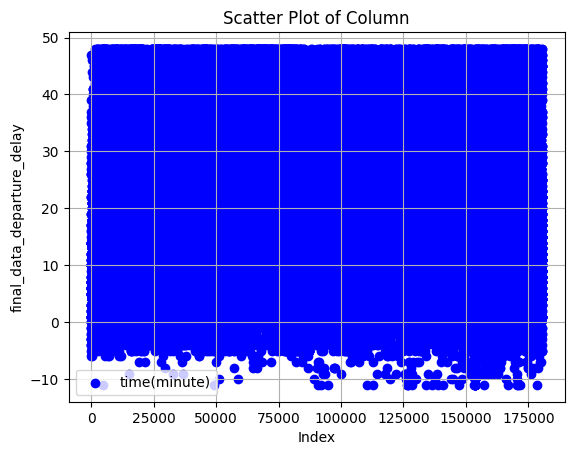

In [ ]:
# Vẽ đồ thị phân tán của Departure
plt.scatter(final_data_Departure.index, final_data_Departure["departure_delay"], color='blue', label='time(minute)')

# Thêm nhãn và tiêu đề
plt.title('Scatter Plot of Column')
plt.xlabel('Index')
plt.ylabel('final_data_departure_delay')
plt.legend()
plt.grid(True)

# Hiển thị đồ thị
plt.show()

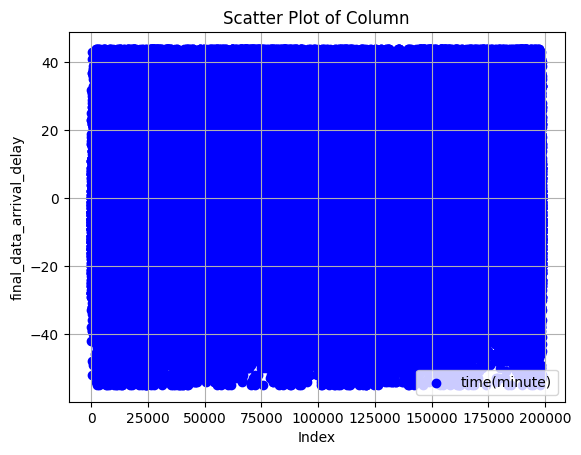

In [ ]:
# Vẽ đồ thị phân tán của Arrival
plt.scatter(final_data_Arrival.index, final_data_Departure["arrival_delay"], color='blue', label='time(minute)')

# Thêm nhãn và tiêu đề
plt.title('Scatter Plot of Column')
plt.xlabel('Index')
plt.ylabel('final_data_arrival_delay')
plt.legend()
plt.grid(True)

# Hiển thị đồ thị
plt.show()

<ipython-input-65-1de2fa225d53>:8: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("drive/MyDrive/SVKT/upload_data/final_data_Departure.csv")


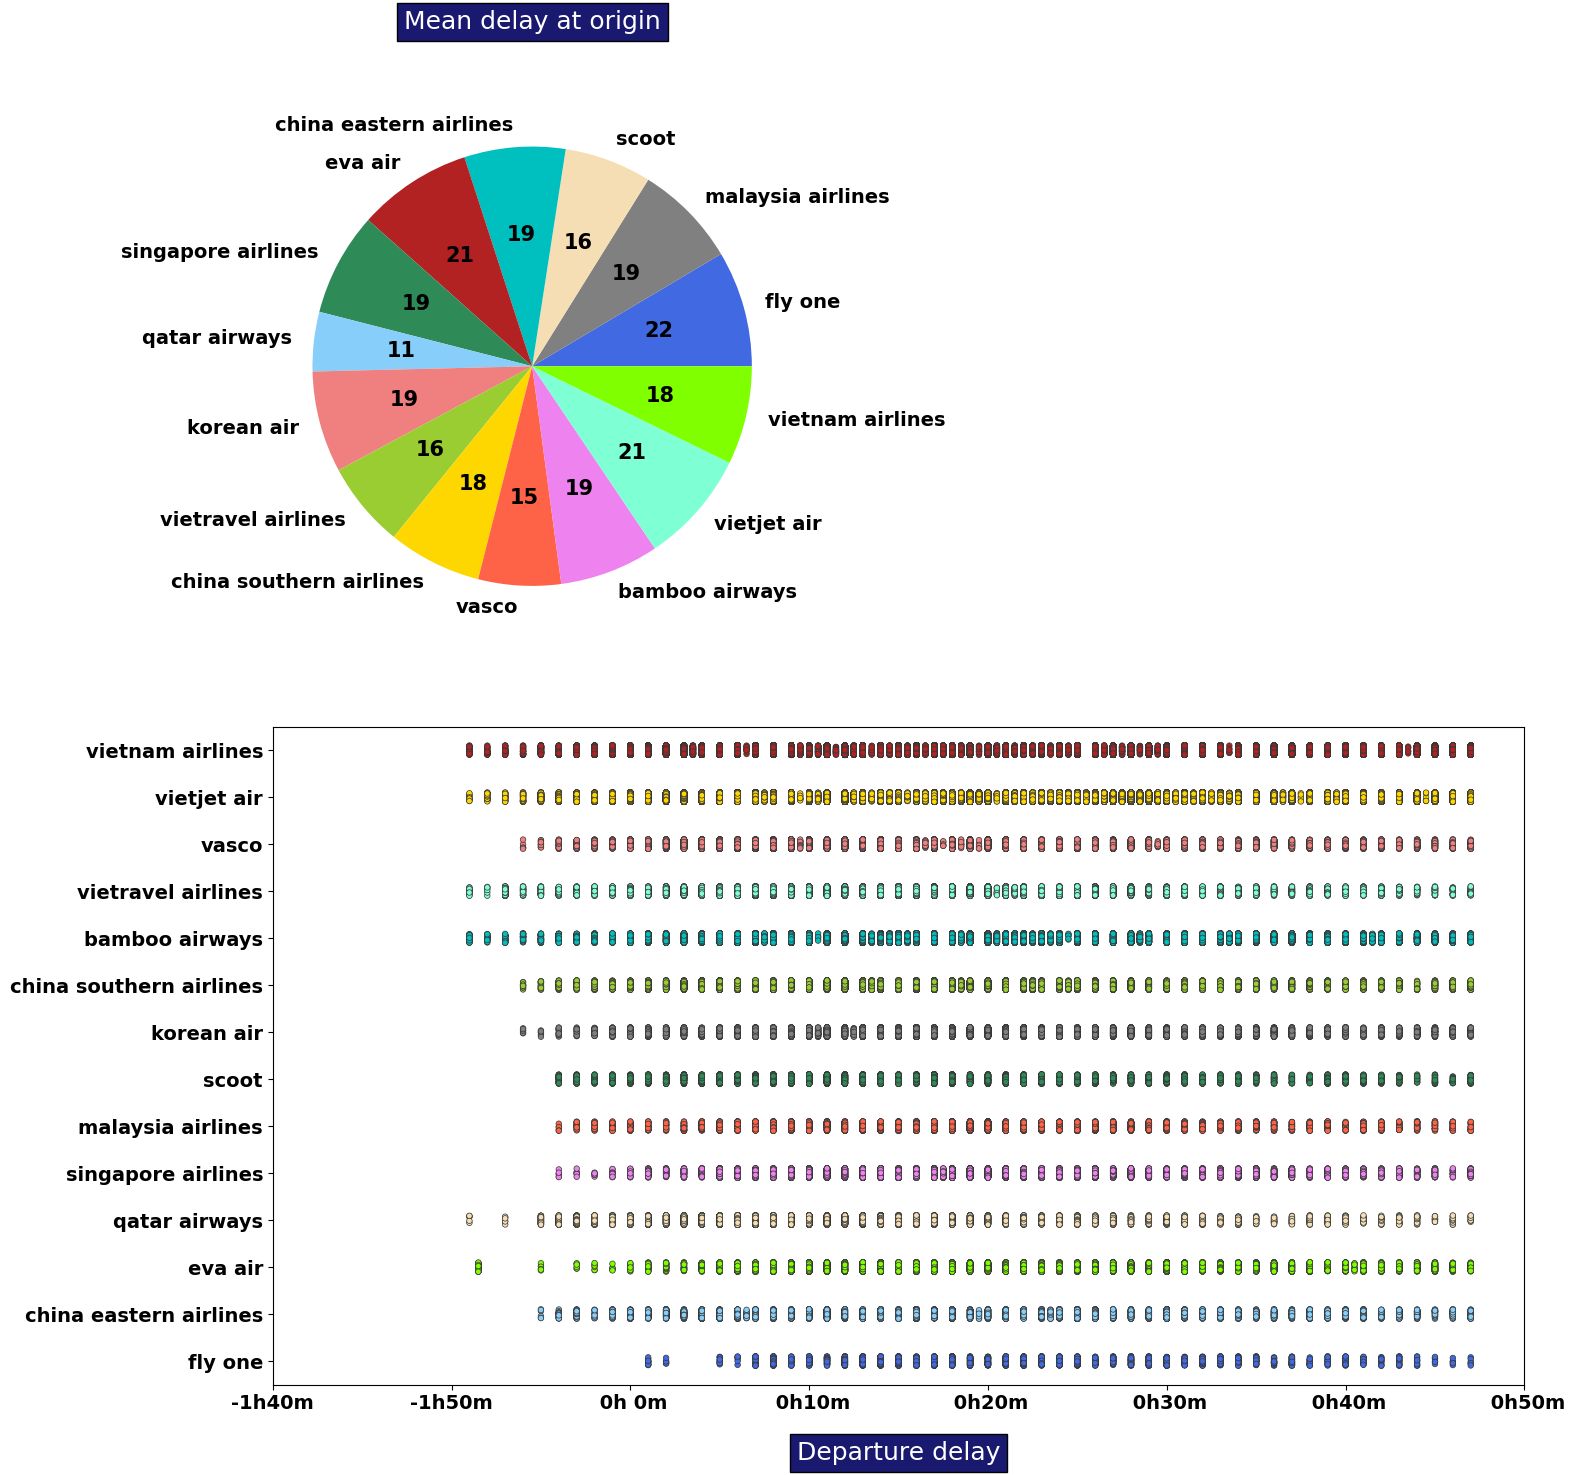

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Load the data
data = pd.read_csv("drive/MyDrive/SVKT/upload_data/final_data_Departure.csv")

# Filter the data to include only the specified airlines
filtered_airlines = ['vn', 'ke', 'qh', 'vj', 'cz', 'qr', '0v', 'tr', 'br', 'mh', 'mu', 'sq', 'vu', '5f']
data = data[data['airline_iataCode'].isin(filtered_airlines)]

def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

# Creation of a dataframe with statistical infos on each airline:
global_stats = data['departure_delay'].groupby(data['airline_name']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')

abbr_companies = data.set_index('airline_iataCode')['airline_name'].to_dict()

# Extract a subset of columns and redefine the airlines labeling
font = {'family': 'sans-serif', 'weight': 'bold', 'size': 15}
plt.rc('font', **font)
df2 = data.loc[:, ['airline_name', 'departure_delay']]
df2['airline_name'] = df2['airline_name'].replace(abbr_companies)

# Define colors
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']

# Create figure and subplots
fig = plt.figure(1, figsize=(16, 15))
gs = GridSpec(2, 2)
#ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[1, :])

# Pie chart nº1: nb of flights
labels = [s for s in global_stats.index]
sizes = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(sizes))]

# Pie chart nº2: mean delay at departure
sizes = global_stats['mean'].values
sizes = [max(s, 0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(sizes))]
patches, texts, autotexts = ax2.pie(sizes, explode=explode, labels=labels,
                                    colors=colors, shadow=False, startangle=0,
                                    autopct=lambda p: '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(labels)):
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor': 'midnightblue', 'pad': 5},
              color='w', fontsize=18)

# Strip plot with all the values reported for the delays
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
ax3 = sns.stripplot(y="airline_name", x="departure_delay", size=4, palette=colors,
                    data=df2, linewidth=0.5, jitter=True, hue="airline_name", legend=False)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticks(ax3.get_xticks())
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x, 60)])
                     for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor': 'midnightblue', 'pad': 5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)

# Adjust layout
plt.tight_layout(w_pad=3)
plt.show()

## VI. MODEL

### DEPARTURE

In [ ]:
# Tạo đường dẫn dữ liệu:
spark = SparkSession.builder.appName("Trainning Model").getOrCreate()
path_data = '/content/drive/My Drive/SVKT/newdata/final_data_Departure.csv'
final_data_Departure = spark.read.csv(path_data, header=True, inferSchema=True)

In [ ]:
string_indexer_airline = StringIndexer(inputCol="airline_name", outputCol="airline_index")
final_data_Departure = string_indexer_airline.fit(final_data_Departure).transform(final_data_Departure)

final_data_Departure = final_data_Departure.withColumn(
    "departure_scheduledTime_numeric",
    unix_timestamp("departure_scheduledTime")
)
assembler = VectorAssembler(
    inputCols=["airline_index","departure_scheduledTime_numeric","temperature (degC)", "relative_humidity (0-1)",
               "wind_direction (deg)","wind_speed (m/s)","total_cloud_cover (0-1)",
               "total_precipitation (mm of water equivalent)"],
    outputCol="features"
)
final_data_Departure = assembler.transform(final_data_Departure)

#### 1.Decision Tree Regressor

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, Imputer
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, Imputer
from pyspark.sql.functions import col
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Khởi tạo Spark session
if 'spark' not in locals():
    spark = SparkSession.builder.appName("Flight Departure Prediction").getOrCreate()

# Imputation - xử lý dữ liệu thiếu
imputer = Imputer(
    inputCols=["arrival_delay", "temperature (degC)", "departure_scheduledTime_numeric", "dewpoint_temperature (degC)",
               "relative_humidity (0-1)", "wind_speed (m/s)", "wind_direction (deg)",
               "total_cloud_cover (0-1)", "total_precipitation (mm of water equivalent)"],
    outputCols=["arrival_delay", "departure_scheduledTime_numeric", "temperature (degC)", "dewpoint_temperature (degC)",
                "relative_humidity (0-1)", "wind_speed (m/s)", "wind_direction (deg)",
                "total_cloud_cover (0-1)", "total_precipitation (mm of water equivalent)"]
)
final_data_Departure = imputer.fit(final_data_Departure).transform(final_data_Departure)

# Vector hóa dữ liệu đầu vào
assembler = VectorAssembler(
    inputCols=["temperature (degC)", "departure_scheduledTime_numeric", "dewpoint_temperature (degC)",
               "relative_humidity (0-1)", "wind_speed (m/s)", "wind_direction (deg)",
               "total_cloud_cover (0-1)", "total_precipitation (mm of water equivalent)"],
    outputCol="features"
)
final_data = assembler.transform(final_data_Departure).select("features", col("departure_delay").alias("label"))

# Chuyển đổi sang NumPy để sử dụng với TensorFlow
data = final_data.rdd.map(lambda row: (row.features, row.label)).collect()
X = np.array([np.array(features) for features, label in data])
y = np.array([label for features, label in data])

# Chia tập dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Xây dựng mô hình DNN
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)  # Lớp đầu ra (hồi quy)
])

# Biên dịch mô hình
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Huấn luyện mô hình
model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32)

# Dự đoán và đánh giá mô hình
y_pred = model.predict(X_test)

# Tính toán RMSE và R²
rmse = np.sqrt(np.mean((y_test - y_pred.flatten())**2))
r2 = 1 - (np.sum((y_test - y_pred.flatten())**2) / np.sum((y_test - np.mean(y_test))**2))

print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)


Root Mean Squared Error (RMSE): 9.826243166990055
R² Score: 0.09089593437864207


#### 2.Random Forest Regressor

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

In [ ]:
# Bước 3: Chia tập dữ liệu thành huấn luyện và kiểm tra
train_data, test_data = final_data_Departure.randomSplit([0.7, 0.3], seed=42)

# Bước 4: Huấn luyện mô hình Random Forest
rf = RandomForestRegressor(featuresCol="features", labelCol="departure_delay", numTrees=100, maxDepth=5,maxBins= 128, seed=42)
rf_model = rf.fit(train_data)

# Bước 5: Dự đoán và đánh giá
predictions = rf_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="departure_delay", predictionCol="prediction", metricName="r2")
r2_score = evaluator.evaluate(predictions)

print("Model R2 Accuracy:", r2_score)
# Optional: Calculate RMSE
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
print("Root Mean Squared Error (RMSE):", rmse)
# Stop SparkSession
spark.stop()

Model R2 Accuracy: 0.07527998331306118
Root Mean Squared Error (RMSE): 10.615358636405004


#### 3.Gradient Boosting Regressor

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Khởi tạo Spark session nếu chưa được khởi tạo
if 'spark' not in locals():
    spark = SparkSession.builder.appName("Flight Departure Prediction").getOrCreate()

# Giả sử final_data_Departure đã được chuẩn bị trước
# Chia dữ liệu thành tập huấn luyện và kiểm tra
train_data, test_data = final_data_Departure.randomSplit([0.7, 0.3], seed=42)

# Huấn luyện mô hình Gradient Boosting
gbt = GBTRegressor(featuresCol="features", labelCol="departure_delay", maxIter=100, maxDepth=3, seed=42, maxBins=128)
gbt_model = gbt.fit(train_data)

# Dự đoán với mô hình Gradient Boosting
train_data_gbt = gbt_model.transform(train_data).withColumnRenamed("prediction", "gbt_prediction")
test_data_gbt = gbt_model.transform(test_data).withColumnRenamed("prediction", "gbt_prediction")

# Giả sử bạn có mô hình Random Forest đã được huấn luyện (rf_model)
# Dự đoán với mô hình Random Forest (nếu cần so sánh)
test_data_rf = rf_model.transform(test_data).withColumnRenamed("departure_delay", "rf_departure_delay")

# Đánh giá mô hình Gradient Boosting
evaluator_rmse = RegressionEvaluator(labelCol="departure_delay", predictionCol="gbt_prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="departure_delay", predictionCol="gbt_prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(test_data_gbt)
r2 = evaluator_r2.evaluate(test_data_gbt)

print(f"Gradient Boosting RMSE: {rmse}")
print(f"Gradient Boosting R²: {r2}")

# Hiển thị kết quả dự đoán từ Gradient Boosting
test_data_gbt.select("departure_delay", "gbt_prediction").show()

# Dừng Spark session sau khi hoàn thành
spark.stop()


Gradient Boosting RMSE: 10.356934443370235
Gradient Boosting R²: 0.1197553976863075
+---------------+------------------+
|departure_delay|    gbt_prediction|
+---------------+------------------+
|           33.0|14.790364828996788|
|           24.0| 15.24825007234419|
|           17.0| 18.15439531231445|
|           -8.0| 15.24825007234419|
|           12.0|15.374720766944632|
|           14.0|19.143396001572242|
|           17.0|15.374720766944632|
|           21.0|19.143396001572242|
|           24.0|15.374720766944632|
|           11.0|19.143396001572242|
|            9.0|15.374720766944632|
|           15.0|20.075129012255935|
|            7.0|14.326324589089293|
|           11.0|16.652422120273123|
|           25.0|16.652422120273123|
|           10.0|16.652422120273123|
|            9.0|11.335013840859203|
|           16.0|17.338857213475414|
|           15.0|20.725541863870735|
|           30.0|20.725541863870735|
+---------------+------------------+
only showing top 20 rows



#### 4.RandomForest Classifier

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, when
from pyspark.sql.types import IntegerType

In [ ]:

# Khởi tạo SparkSession
spark = SparkSession.builder.appName("FlightDelayAnalysis").getOrCreate()

# Định nghĩa các khoảng thời gian trễ và nhãn
bins = [-10, 14, 24, float('inf')]
labels = ['0-14 phút', '14-24 phút', 'Trên 24 phút']

# Thêm cột 'Khoảng trễ' vào DataFrame
final_data_Departure = final_data_Departure.withColumn(
    'Khoảng trễ',
    when((col('departure_delay') >= bins[0]) & (col('departure_delay') < bins[1]), labels[0])
    .when((col('departure_delay') >= bins[1]) & (col('departure_delay') < bins[2]), labels[1])
    .when(col('departure_delay') >= bins[2], labels[2])
)


# Đếm số lượng chuyến bay trong mỗi khoảng trễ
delay_counts = final_data_Departure.groupBy('Khoảng trễ').count().orderBy('Khoảng trễ')


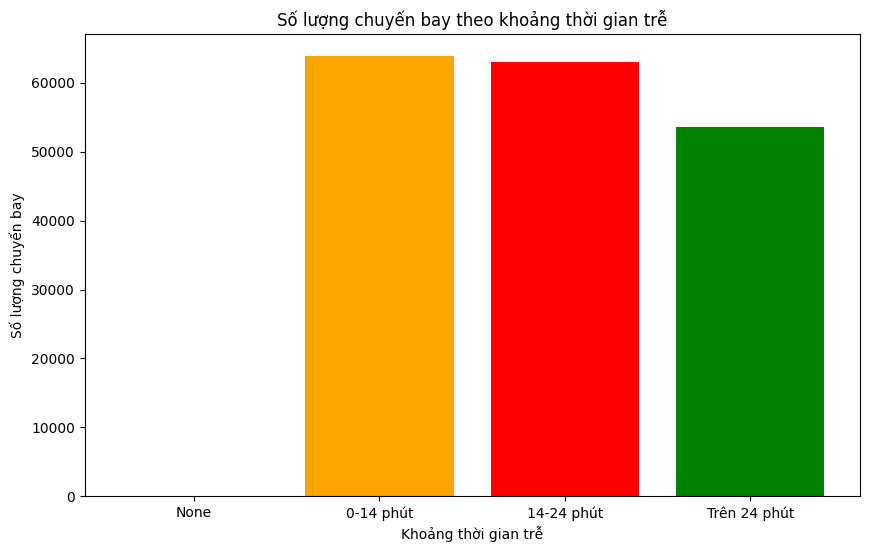

In [ ]:
import matplotlib.pyplot as plt

# Chuyển đổi sang Pandas DataFrame
delay_counts_pd = delay_counts.toPandas()

# Chuyển đổi các giá trị trong cột 'Khoảng trễ' thành chuỗi
delay_counts_pd['Khoảng trễ'] = delay_counts_pd['Khoảng trễ'].astype(str)

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
plt.bar(delay_counts_pd['Khoảng trễ'], delay_counts_pd['count'], color=['green', 'orange', 'red'])

# Thêm tiêu đề và nhãn trục
plt.title('Số lượng chuyến bay theo khoảng thời gian trễ')
plt.xlabel('Khoảng thời gian trễ')
plt.ylabel('Số lượng chuyến bay')

# Hiển thị biểu đồ
plt.show()

In [ ]:

final_data_Departure = final_data_Departure.withColumn(
    "delay_class",
    when(col("departure_delay") <= 5, 0)
    .when((col("departure_delay") > 5) & (col("departure_delay") <= 30), 1)
    .otherwise(2)
)
# 8. Chia dữ liệu thành tập huấn luyện và kiểm tra
train_data, test_data = final_data_Departure.randomSplit([0.7, 0.3], seed=42)

# 9. Huấn luyện Random Forest Classifier
final_data_Departure = RandomForestClassifier(featuresCol="features", labelCol="delay_class", numTrees=100, maxDepth=5, seed=42, maxBins=128)
rf_model = final_data_Departure.fit(train_data)

# 10. Dự đoán với Random Forest Classifier
predictions = rf_model.transform(test_data)

# 11. Đánh giá mô hình
evaluator = MulticlassClassificationEvaluator(labelCol="delay_class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# 12. Hiển thị kết quả
predictions.select("departure_delay", "delay_class", "prediction").show()

# 13. Dừng SparkSession
spark.stop()

Accuracy: 0.751645223306714
+---------------+-----------+----------+
|departure_delay|delay_class|prediction|
+---------------+-----------+----------+
|           33.0|          2|       1.0|
|           24.0|          1|       1.0|
|           17.0|          1|       1.0|
|           -8.0|          0|       1.0|
|           12.0|          1|       1.0|
|           14.0|          1|       1.0|
|           17.0|          1|       1.0|
|           21.0|          1|       1.0|
|           24.0|          1|       1.0|
|           11.0|          1|       1.0|
|            9.0|          1|       1.0|
|           15.0|          1|       1.0|
|            7.0|          1|       1.0|
|           11.0|          1|       1.0|
|           25.0|          1|       1.0|
|           10.0|          1|       1.0|
|            9.0|          1|       1.0|
|           16.0|          1|       1.0|
|           15.0|          1|       1.0|
|           30.0|          1|       1.0|
+---------------+-----------+

In [ ]:
# Lưu mô hình đã được huấn luyện
import pyspark

model_path = "drive/MyDrive/SVKT/newdata/RandomForest_Departure_Model"
rf_model.write().overwrite().save(model_path)
print(f"Model saved at: {model_path}")


Model saved at: drive/MyDrive/SVKT/newdata/RandomForest_Departure_Model


### ARRIVAL

In [ ]:
# Tạo đường dẫn dữ liệu:
spark = SparkSession.builder.appName("Trainning Model").getOrCreate()
path_data = '/content/drive/My Drive/SVKT/upload_data/final_data_Arrival.csv'
final_data_Arrival = spark.read.csv(path_data, header=True, inferSchema=True)

In [ ]:
string_indexer_airline = StringIndexer(inputCol="airline_name", outputCol="airline_index")
final_data_Arrival = string_indexer_airline.fit(final_data_Arrival).transform(final_data_Arrival)
final_data_Arrival = final_data_Arrival.withColumn(
    "arrival_scheduledTime_numeric",
    unix_timestamp("Arrival_scheduledTime")
)
assembler = VectorAssembler(
    inputCols=["airline_index","arrival_scheduledTime_numeric","temperature (degC)", "relative_humidity (0-1)",
               "wind_direction (deg)","wind_speed (m/s)","total_cloud_cover (0-1)",
               "total_precipitation (mm of water equivalent)"],
    outputCol="features"
)
final_data_Arrival = assembler.transform(final_data_Arrival)

#### 1.Decision Tree Regressor


In [ ]:
imputer = Imputer(
    inputCols=["arrival_delay", "temperature (degC)","arrival_scheduledTime_numeric" ,"dewpoint_temperature (degC)",
    "relative_humidity (0-1)", "wind_speed (m/s)", "wind_direction (deg)",
    "total_cloud_cover (0-1)", "total_precipitation (mm of water equivalent)"],
    outputCols=["arrival_delay","arrival_scheduledTime_numeric" ,"temperature (degC)", "dewpoint_temperature (degC)",
    "relative_humidity (0-1)", "wind_speed (m/s)", "wind_direction (deg)",
    "total_cloud_cover (0-1)", "total_precipitation (mm of water equivalent)"]
)
final_data_Arrival = imputer.fit(final_data_Arrival).transform(final_data_Arrival)
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_data, test_data = final_data_Arrival.randomSplit([0.8, 0.2], seed=42)

# Khởi tạo và huấn luyện mô hình Decision Tree Regressor
dtr = DecisionTreeRegressor(featuresCol="features", labelCol="arrival_delay",maxDepth=5, maxBins=128, seed=42)
model = dtr.fit(train_data)

# Dự đoán trên tập kiểm tra
predictions = model.transform(test_data)

# Đánh giá mô hình
evaluator_rmse = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="r2")
rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

# Dừng SparkSession
spark.stop()

Root Mean Squared Error (RMSE): 16.55357297509805
R² Score: 0.14400828400023502


#### 2.Random Forest Regressor

In [ ]:
# Bước 3: Chia tập dữ liệu thành huấn luyện và kiểm tra
train_data, test_data = final_data_Arrival.randomSplit([0.7, 0.3], seed=42)

# Bước 4: Huấn luyện mô hình Random Forest
rf = RandomForestRegressor(featuresCol="features", labelCol="arrival_delay", numTrees=100, maxDepth=5,maxBins= 128, seed=42)
rf_model = rf.fit(train_data)

# Bước 5: Dự đoán và đánh giá
predictions = rf_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="r2")
r2_score = evaluator.evaluate(predictions)

print("Model R2 Accuracy:", r2_score)
# Optional: Calculate RMSE
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
print("Root Mean Squared Error (RMSE):", rmse)
# Stop SparkSession
spark.stop()


Model R2 Accuracy: 0.1395781339769675
Root Mean Squared Error (RMSE): 16.61621367466129


#### 3.Gradient Boosting Regressor

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Khởi tạo Spark session nếu chưa được khởi tạo
if 'spark' not in locals():
    spark = SparkSession.builder.appName("Flight Arrival Prediction").getOrCreate()

# Giả sử final_data_Departure đã được chuẩn bị trước
# Chia dữ liệu thành tập huấn luyện và kiểm tra
train_data, test_data = final_data_Arrival.randomSplit([0.7, 0.3], seed=42)

# Huấn luyện mô hình Gradient Boosting
gbt = GBTRegressor(featuresCol="features", labelCol="arrival_delay", maxIter=100, maxDepth=3, seed=42, maxBins=128)
gbt_model = gbt.fit(train_data)

# Dự đoán với mô hình Gradient Boosting
train_data_gbt = gbt_model.transform(train_data).withColumnRenamed("prediction", "gbt_prediction")
test_data_gbt = gbt_model.transform(test_data).withColumnRenamed("prediction", "gbt_prediction")

# Giả sử bạn có mô hình Random Forest đã được huấn luyện (rf_model)
# Dự đoán với mô hình Random Forest (nếu cần so sánh)
test_data_rf = rf_model.transform(test_data).withColumnRenamed("arrival_delay", "rf_arrival_delay")

# Đánh giá mô hình Gradient Boosting
evaluator_rmse = RegressionEvaluator(labelCol="arrival_delay", predictionCol="gbt_prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="arrival_delay", predictionCol="gbt_prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(test_data_gbt)
r2 = evaluator_r2.evaluate(test_data_gbt)

print(f"Gradient Boosting RMSE: {rmse}")
print(f"Gradient Boosting R²: {r2}")

# Hiển thị kết quả dự đoán từ Gradient Boosting
test_data_gbt.select("arrival_delay", "gbt_prediction").show()

# Dừng Spark session sau khi hoàn thành
spark.stop()


Gradient Boosting RMSE: 16.302426257092975
Gradient Boosting R²: 0.1717684107337748
+-------------+-------------------+
|arrival_delay|     gbt_prediction|
+-------------+-------------------+
|          3.5|  9.003519636743441|
|        -24.0| -7.409314096969518|
|        -24.0| -8.619515859706572|
|        -24.0| -8.934175901916827|
|         -2.5|-11.530780049084235|
|         -2.5|-11.631909651271688|
|         -2.5|-11.718772358118231|
|        -10.0|-17.635205419203338|
|        -10.0|-21.635660192843975|
|        -10.0|-20.657787782138332|
|        -35.5| -35.52467924498358|
|        -35.5| -36.00737488736586|
|        -35.5| -35.85228614603269|
|        -35.5| -35.89673722098783|
|        -35.5|-35.967249913925905|
|        -35.5| -36.07881461526408|
|        -35.5| -32.67535343814649|
|        -14.0|   -9.4759817749925|
|        -13.0| -8.216030040863656|
|        -13.0| -7.484841160195855|
+-------------+-------------------+
only showing top 20 rows



#### 4.RandomForest Classifier

In [ ]:

# Khởi tạo SparkSession
spark = SparkSession.builder.appName("FlightDelayAnalysis").getOrCreate()

# Định nghĩa các khoảng thời gian trễ và nhãn
bins = [-10, 14, 24, float('inf')]
labels = ['0-14 phút', '14-24 phút', 'Trên 24 phút']

# Thêm cột 'Khoảng trễ' vào DataFrame
final_data_Arrival = final_data_Arrival.withColumn(
    'Khoảng trễ',
    when((col('arrival_delay') >= bins[0]) & (col('arrival_delay') < bins[1]), labels[0])
    .when((col('arrival_delay') >= bins[1]) & (col('arrival_delay') < bins[2]), labels[1])
    .when(col('arrival_delay') >= bins[2], labels[2])
)


# Đếm số lượng chuyến bay trong mỗi khoảng trễ
delay_counts = final_data_Arrival.groupBy('Khoảng trễ').count().orderBy('Khoảng trễ')


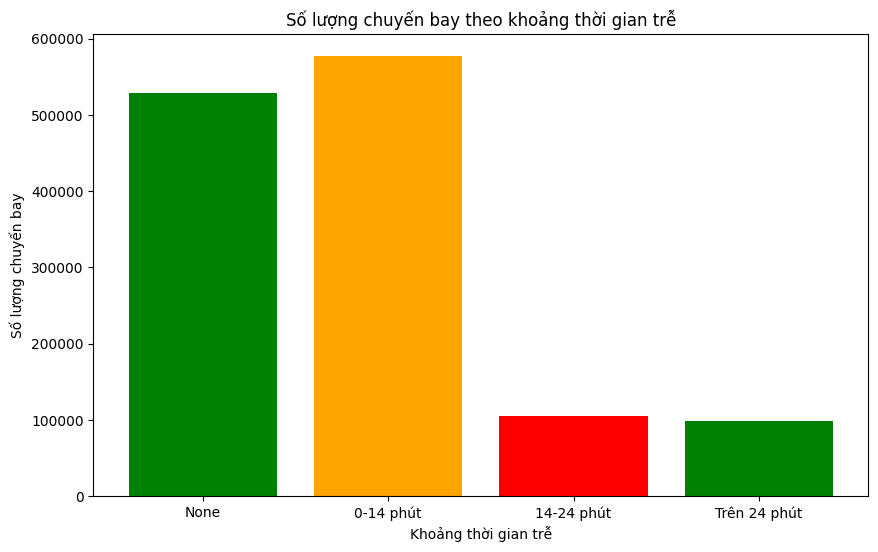

In [ ]:
import matplotlib.pyplot as plt

# Chuyển đổi sang Pandas DataFrame
delay_counts_pd = delay_counts.toPandas()

# Chuyển đổi các giá trị trong cột 'Khoảng trễ' thành chuỗi
delay_counts_pd['Khoảng trễ'] = delay_counts_pd['Khoảng trễ'].astype(str)

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
plt.bar(delay_counts_pd['Khoảng trễ'], delay_counts_pd['count'], color=['green', 'orange', 'red'])

# Thêm tiêu đề và nhãn trục
plt.title('Số lượng chuyến bay theo khoảng thời gian trễ')
plt.xlabel('Khoảng thời gian trễ')
plt.ylabel('Số lượng chuyến bay')

# Hiển thị biểu đồ
plt.show()

In [ ]:

spark = SparkSession.builder.appName("Trainning Model").getOrCreate()

Q1, Q3 = data.approxQuantile("arrival_delay", [0.25, 0.75], 0.05)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_filter = data.filter((data["arrival_delay"] >= lower_bound) & (data["arrival_delay"] <= upper_bound))

data_with_class = df_filter.withColumn(
    "delay_class",
    when(col("arrival_delay") <= 5, 0)
    .when((col("arrival_delay") > 5) & (col("arrival_delay") <= 30), 1)
    .otherwise(2)

)

data_with_class = data_with_class.withColumn("delay_class", col("delay_class").cast(IntegerType()))

string_indexer_airline = StringIndexer(inputCol="Airline", outputCol="airline_index")
string_indexer_to = StringIndexer(inputCol="arrival_iataCode", outputCol="arrival_iataCode_index")  # Tạo StringIndexer cho cột "To"
data = string_indexer_airline.fit(data_with_class).transform(data_with_class)
data = string_indexer_to.fit(data).transform(data)
# 7. Tạo vector đặc trưng
assembler = VectorAssembler(
    inputCols=["arrival_iataCode_index","departure_delay","airline_index", "temperature (degC)", "relative_humidity (0-1)",
               "wind_direction (deg)", "total_cloud_cover (0-1)",
               "total_precipitation (mm of water equivalent)"],
    outputCol="features"
)
data = assembler.transform(data)

# 8. Chia dữ liệu thành tập huấn luyện và kiểm tra
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

# 9. Huấn luyện Random Forest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="delay_class", numTrees=100, maxDepth=10, seed=42, maxBins=128)
rf_model = rf.fit(train_data)

# 10. Dự đoán với Random Forest Classifier
predictions = rf_model.transform(test_data)

# 11. Đánh giá mô hình
evaluator = MulticlassClassificationEvaluator(labelCol="delay_class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# 12. Hiển thị kết quả
predictions.select("arrival_delay", "delay_class", "prediction").show()

# 13. Dừng SparkSession
spark.stop()


Accuracy: 0.8033946251768034
+-------------+-----------+----------+
|arrival_delay|delay_class|prediction|
+-------------+-----------+----------+
|         60.0|          2|       2.0|
|         47.0|          2|       2.0|
|         92.0|          2|       2.0|
|         92.0|          2|       2.0|
|         69.0|          2|       2.0|
|         64.0|          2|       2.0|
|         64.0|          2|       2.0|
|         86.0|          2|       2.0|
|        104.0|          2|       2.0|
|          0.0|          0|       0.0|
|         72.0|          2|       2.0|
|         38.0|          2|       2.0|
|         38.0|          2|       2.0|
|         55.0|          2|       2.0|
|         65.0|          2|       2.0|
|         58.0|          2|       2.0|
|         58.0|          2|       2.0|
|         80.0|          2|       2.0|
|         49.0|          2|       2.0|
|         54.0|          2|       2.0|
+-------------+-----------+----------+
only showing top 20 rows



In [ ]:
# Lưu mô hình đã được huấn luyện
import pyspark

model_path = "drive/MyDrive/SVKT/newdata/RandomForest_Arrival_Model"
rf_model.write().overwrite().save(model_path)
print(f"Model saved at: {model_path}")

Model saved at: drive/MyDrive/SVKT/newdata/RandomForest_Arrival_Model


Sau khi thử nghiệm những mô hình thì nhóm em quyết định lựa chọn mô hình RandomForest Classifier với độ chính xác cao nhất.

## VI.CONCLUSION

###1. Flight Delay Prediction

DEPARTURE

- Đạt được độ chính xác:
  - Decision Tree Regressor (9.08%)
  - Random Forest Regressor (7,52%)
  - Gradient Boosting Regressor (11,98%)
  - RandomForest Classifier (75,16%)

ARRIVAL

- Đạt được độ chính xác:
  - Decision Tree Regressor (14,4%)
  - Random Forest Regressor (13,96%)
  - Gradient Boosting Regressor (17,18%)
  - RandomForest Classifier (80,34%)

###2. Crawl realtime data in FLightradar24.com

Đầu Tiên ta sẽ lấy dữ liệu trực tiếp từ Flightradar24.com

In [ ]:
# THư viện và danh sách sân bay
from playwright.sync_api import sync_playwright
import pandas as pd
from datetime import datetime, timedelta
import os


airports = ['HAN','SGN', 'HAH', 'VCA', 'PQC', 'DAD']

def find_indices(array,keyword):
    return [i for i, value in enumerate(array) if keyword in value]


ModuleNotFoundError: No module named 'playwright'

In [ ]:
# Hàm truy cập trang web và get cookie
def page_create():
    with sync_playwright() as p:
        browser = p.chromium.launch(headless=True)
        context = browser.new_context(viewport={'width': 1920, 'height': 1080})
        page = context.new_page()
        page.route("**/*.{png,jpg,jpeg,gif,webp}", lambda route: route.abort())
        page.route("**/*.css", lambda route: route.abort())
        page.goto(f"https://www.flightradar24.com",timeout=60000)
        try:
            page.click("#onetrust-accept-btn-handler")
            page.wait_for_timeout(2000)
        except:
            print('Error: Cookies element not found on page.')
            browser.close()
    return page ,browser

In [ ]:
# Lấy danh sách các chuyến bay trong ngày hôm nay
def fetch_table_data(page,airport,type):
    print(f"[INFO] Navigating to URL: {airport}")
    page.goto(f"https://www.flightradar24.com/data/airports/{airport}/{type}", timeout=60000)
    # Tải thêm dữ liệu bằng cách cuộn
    print("[INFO] Loading additional data by clicking 'Load earlier' buttons...")
    while True:
        try:
            load_more_button = page.locator("#cnt-data-content > div > div.tab-pane.p-l.active > div > aside > div.row.cnt-schedule-table > table > thead > tr:nth-child(2) > td > button")
            if not load_more_button.is_visible():
                print("[INFO] No more 'Load earlier' buttons visible.")
                break
            print("[INFO] Clicking 'Load earlier' button...")
            load_more_button.click()
            page.wait_for_timeout(2000)  # Đợi dữ liệu tải thêm
        except:
            print("[INFO] No 'Load earlier' button found or error occurred.")
            break

    # Lấy dữ liệu từ bảng
    print("[INFO] Extracting table data...")
    table_rows = page.locator("table.table-condensed > tbody > tr")
    data = {
        "Flight Code":[],
        "Airline":[]
    }
    day = (datetime.now()-timedelta(days= 1)).strftime("%A")  # Hôm nay
    next_day = (datetime.now()).strftime("%A")  # Ngày mai

    for i in range(table_rows.count()):
        row = table_rows.nth(i)
        if row.get_attribute("class") == "row-date-separator hidden-xs hidden-sm":
            if next_day.lower() in row.text_content().lower():
                print("[INFO] Reached the next day's data. Stopping extraction.")
                break  # Ngừng nếu gặp ngày hôm sau
            continue
        cols = row.locator("td").all_text_contents()
        if len(cols) == 7:  # Chỉ xử lý nếu đủ cột
            data["Flight Code"].append(cols[1])
            data["Airline"].append(cols[3])

    return data


In [ ]:
# Hàm lấy dữ liệu delay dept và arr nếu có (phục vụ cho việc cập nhật model sau này với dữ liệu thực tế)
def init_page_delay(codes, page, browser):
    data = {
        "Flight Code": [],
        "Date": [],
        "From": [],
        "To": [],
        "Time Duration": [],
        "Scheduled Departure": [],
        "Actual Departure": [],
        "Scheduled Arrival": [],
        "Actual Arrival": [],
    }
    for code in codes:
        try:
            print(f'[INFO] go to page flight code :{code}')
            page.goto(f"https://www.flightradar24.com/data/flights/{code}", timeout=60000)
            data = delays(code, page, data)
            print(f'[SUCCESS] complete get data  :{code}')
        except Exception as e:
            print(f"[ERROR] Failed to process flight {code}: {str(e)}")
            continue
    return data

def delays(code, page, data):
    table = page.locator("#tbl-datatable")
    if not table.count():
        print(f'[WARNING] Table not found for flight {code}')
        return data

    dt = (datetime.now()).strftime('%d %b %Y')
    past_time = False
    rows = table.locator("tr")

    try:
        for i in range(rows.count()):
            row = rows.nth(i)
            cells = row.locator("td")

            if cells.count() >= 2:
                temp = re.split(r'\n|\t|\xa0', row.inner_text())
                row_date = temp[1]
                if dt == row_date:
                    time_duration = temp[2]
                    if time_duration == "-":
                        continue
                    scheduled_departures = temp[6]
                    actual_departures = temp[9]
                    scheduled_arrival = temp[12]
                    dept_iata = temp[15]
                    arr_iata = temp[18]
                    sche_arr = datetime.strptime(scheduled_arrival, "%I:%M %p")
                    hours, minutes = map(int, time_duration.split(":"))
                    duration = timedelta(hours=hours, minutes=minutes)
                    actual_arrival = (sche_arr + duration).strftime("%I:%M %p")

                    data["Time Duration"].append(time_duration)
                    data["Flight Code"].append(code)
                    data["Date"].append(row_date)
                    data["From"].append(dept_iata)
                    data["To"].append(arr_iata)
                    data["Scheduled Departure"].append(scheduled_departures)
                    data["Actual Departure"].append(actual_departures)
                    data["Scheduled Arrival"].append(scheduled_arrival)
                    data["Actual Arrival"].append(actual_arrival)
    except Exception as e:
        print(f"[ERROR] Error processing flight {code}: {str(e)}")

    return data


In [ ]:
# Hàm lấy dữ liêu hôm nay của từng sân bay
def Today_flight_data(airport):
    with sync_playwright() as playwright:
        try:
            # Launch browser
            browser = playwright.chromium.launch(headless=True)
            context = browser.new_context(viewport={'width': 1920, 'height': 1080})
            page = context.new_page()

            # Block unnecessary resources
            page.route("**/*.{png,jpg,jpeg,gif,webp}", lambda route: route.abort())
            page.route("**/*.css", lambda route: route.abort())
            # Navigate to initial page and handle cookies
            page.goto("https://www.flightradar24.com", timeout=60000)
            try:
                page.click("#onetrust-accept-btn-handler")
                print("Cookie Accepted")
                page.wait_for_timeout(2000)
            except:
                print('[INFO] No cookie consent needed or already accepted')


            arr = fetch_table_data(page,airport,'arrivals')
            df = pd.DataFrame(arr)
            # Loại bỏ dấu '-' ở cuối cột 'Airline'
            df['Airline'] = df['Airline'].str.rstrip('- ')
            # Loại bỏ các dòng trùng lặp dựa trên cột 'Flight Code'
            df = df.drop_duplicates(subset='Flight Code')
            delays = init_page_delay(arr['Flight Code'],page,browser)
            delays = pd.DataFrame(delays)
            df = delays.merge(arr[['Flight Code', 'Airline']], on='Flight Code', how='left')
            df.to_csv(f'{airport}_rawdata.csv')



        except Exception as e:
            print(f"[ERROR] An error occurred: {str(e)}")
        finally:
            if 'browser' in locals():
                browser.close()
            print("[INFO] Browser closed")

if __name__ == "__main__":
    for a in airports:
        Today_flight_data(a)


Lấy dữ liệu thời tiết mỗi ngày ở các sân bay


In [ ]:
import requests
import pandas as pd
import io
from datetime import datetime, timedelta,timezone
import os

# Danh sách mã ICAO/IATA của các sân bay
airports = [
    {"name": "HAN", "lat": "21.2187","lon":"105.8041"},
    {"name": "DAD", "lat": "16.0570","lon":"108.2025"},
    {"name": "SGN", "lat": "10.8170","lon":"106.6566"},
    {"name": "HAH", "lat": "20.8186","lon":"106.7230"},
    {"name": "PQC", "lat": "10.1627","lon":"103.9982"},
    {"name": "VCA", "lat": "10.0805","lon":"105.7122"}
]

# API key của bạn
api_key = 'c7151e9a89bc4960b0fa37234e6cf14b'

def GetWeather():
    # Thời gian bắt đầu và kết thúc (forecast 1 ngày từ thời điểm hiện tại)
    start_date = (datetime.now()-timedelta(days=7))
    end_date = start_date + timedelta(days=7)

    # Định dạng thời gian cho API
    start_str = start_date.strftime('%Y-%m-%dT%H:%M:%S')
    end_str = end_date.strftime('%Y-%m-%dT%H:%M:%S')
    now = (datetime.now()).strftime("%A %d-%m-%Y")
    # Lấy dữ liệu thời tiết cho từng sân bay
    for airport in airports:
        print(f"Đang lấy dữ liệu forecast cho sân bay {airport['name']}...")

        response = requests.get(
            'https://api.oikolab.com/weather',
            params={
                'param': ['temperature', 'dewpoint_temperature', 'relative_humidity',
                          'wind_speed', 'wind_direction', 'total_cloud_cover',
                          'total_precipitation'],
                'lat': float(airport['lat']),
                'lon': float(airport['lon']),
                'model': 'GFS',  # Model thời tiết
                'start': start_str,
                'end': end_str,
                'freq': 'H',  # Lấy dữ liệu theo giờ
                'resample_method': 'mean',
                'format': 'csv',
            },
            headers={'api-key': api_key}
        )

        # Kiểm tra trạng thái yêu cầu
        if response.status_code == 200:
            # Lưu dữ liệu trả về dưới dạng văn bản
            csv_data = response.text

            # Đọc dữ liệu CSV vào DataFrame
            airport_data = pd.read_csv(io.StringIO(csv_data))

            # Thêm cột mã sân bay
            airport_data['Airport'] = airport['name']
            folder_path = f'{now}/Weather'
            file_name = f"Weather_{airport['name']}"
            # file_path = os.path.join(folder_path, file_name)
            # Tạo thư mục nếu chưa tồn tại
            os.makedirs(folder_path, exist_ok=True)
            # Tạo tên file dựa trên mã sân bay
            output_file = f"{file_name}.csv"

            # Xuất dữ liệu ra file CSV
            airport_data.to_csv(output_file, index=False, encoding='utf-8')
            print(f"Dữ liệu cho sân bay {airport['name']} đã được lưu vào file: {output_file}")
        else:
            print(f"Yêu cầu API thất bại cho sân bay {airport} với mã lỗi: {response.status_code}")
            print(f"Nội dung phản hồi: {response.text}")



if __name__ == "__main__":
    # Gọi hàm để lấy dữ liệu và lưu mỗi sân bay vào một file CSV riêng
    GetWeather()


Đang lấy dữ liệu forecast cho sân bay HAN...
Dữ liệu cho sân bay HAN đã được lưu vào file: Weather_HAN.csv
Đang lấy dữ liệu forecast cho sân bay DAD...
Dữ liệu cho sân bay DAD đã được lưu vào file: Weather_DAD.csv
Đang lấy dữ liệu forecast cho sân bay SGN...
Dữ liệu cho sân bay SGN đã được lưu vào file: Weather_SGN.csv
Đang lấy dữ liệu forecast cho sân bay HAH...
Dữ liệu cho sân bay HAH đã được lưu vào file: Weather_HAH.csv
Đang lấy dữ liệu forecast cho sân bay PQC...
Dữ liệu cho sân bay PQC đã được lưu vào file: Weather_PQC.csv
Đang lấy dữ liệu forecast cho sân bay VCA...
Dữ liệu cho sân bay VCA đã được lưu vào file: Weather_VCA.csv


![Hinh2](https://i.imgur.com/jHhud1R.jpeg)

In [ ]:

import pandas as pd
from datetime import datetime, timedelta

airports = ['HAN','SGN', 'HAH', 'VCA', 'PQC', 'DAD']
for airport in airports:
    # Đọc dữ liệu từ hai file CSV
    flights = pd.read_csv(f'{airport}.csv')
    weather = pd.read_csv(f'Weather_{airport}.csv')

    # Chuyển các cột thời gian sang định dạng datetime
    flights['Scheduled Arrival'] = pd.to_datetime(flights['Date'] + ' ' + flights['Scheduled Arrival'])
    weather['datetime (UTC)'] = pd.to_datetime(weather['datetime (UTC)'])

    # Hàm tìm thời tiết gần nhất dựa trên 'Scheduled Arrival'
    def find_nearest_weather_time(arrival_time, weather_times):
        nearest_idx = (weather_times - arrival_time).abs().idxmin()
        return nearest_idx

    # Áp dụng hàm tìm thời tiết gần nhất cho từng dòng trong flights
    nearest_indices = flights['Scheduled Arrival'].apply(find_nearest_weather_time, weather_times=weather['datetime (UTC)'])

    # Lấy dữ liệu thời tiết tương ứng với chỉ số tìm được
    nearest_weather = weather.loc[nearest_indices].reset_index(drop=True)

    # Ghép dữ liệu chuyến bay với thời tiết tương ứng
    merged_df = pd.concat([flights, nearest_weather], axis=1)

    # Xuất dữ liệu ra file CSV
    merged_df.to_csv(f'{airport}_rawdata.csv', index=False)

    print("Ghép dữ liệu thành công!")


Xử lý một số dữ liệu đơn giản

In [ ]:
# DỔi giờ
import pandas as pd
from datetime import datetime, timedelta

airports = ['HAN','SGN', 'HAH', 'VCA', 'PQC', 'DAD']
for airport in airports:
    # Read data from CSV
    df = pd.read_csv(f'{airport}_rawdata.csv')

    # 1. Xóa cột Actual Arrival
    df.drop(columns=['Actual Arrival'], inplace=True)
    df.drop(columns=['model (name)','coordinates (lat,lon)'], inplace=True)

    # 2. Chuyển các cột Scheduled Departure và Actual Departure thành định dạng giống Scheduled Arrival (dạng datetime)
    # Chuyển cột Date sang định dạng datetime
    df['Date'] = pd.to_datetime(df['Date'], format='%d %b %Y')

    # Kết hợp cột Date với Scheduled Departure và Actual Departure để tạo thành datetime
    df['Scheduled Departure'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Scheduled Departure'].astype(str), format='%Y-%m-%d %I:%M %p')
    df['Actual Departure'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Actual Departure'].astype(str), format='%Y-%m-%d %I:%M %p')

    # 3. Thêm cột Actual Arrival bằng Actual Departure + Time Duration
    # Chuyển Time Duration sang định dạng timedelta để cộng với Actual Departure
    df['Time Duration'] = pd.to_timedelta(df['Time Duration'] + ':00')  # giả sử Time Duration dạng HH:MM
    df['Actual Arrival'] = pd.to_datetime(df['Actual Departure'].astype(str)) + df['Time Duration']

    # 4. Thêm 2 cột Delay Departure và Delay Arrival
    df['Delay Departure'] = (pd.to_datetime(df['Actual Departure'].astype(str)) - pd.to_datetime(df['Scheduled Departure'].astype(str))).dt.total_seconds() / 60  # Độ trễ tính bằng phút
    df['Delay Arrival'] = (pd.to_datetime(df['Actual Arrival'].astype(str)) - pd.to_datetime(df['Scheduled Arrival'].astype(str))).dt.total_seconds() / 60  # Độ trễ tính bằng phút

    # Lưu kết quả vào một file CSV mới
    df.to_csv(f'train_data/{airport}.csv', index=False)




###Sau đó sử dụng streamlit để trình bày các chuyến bay thực tế


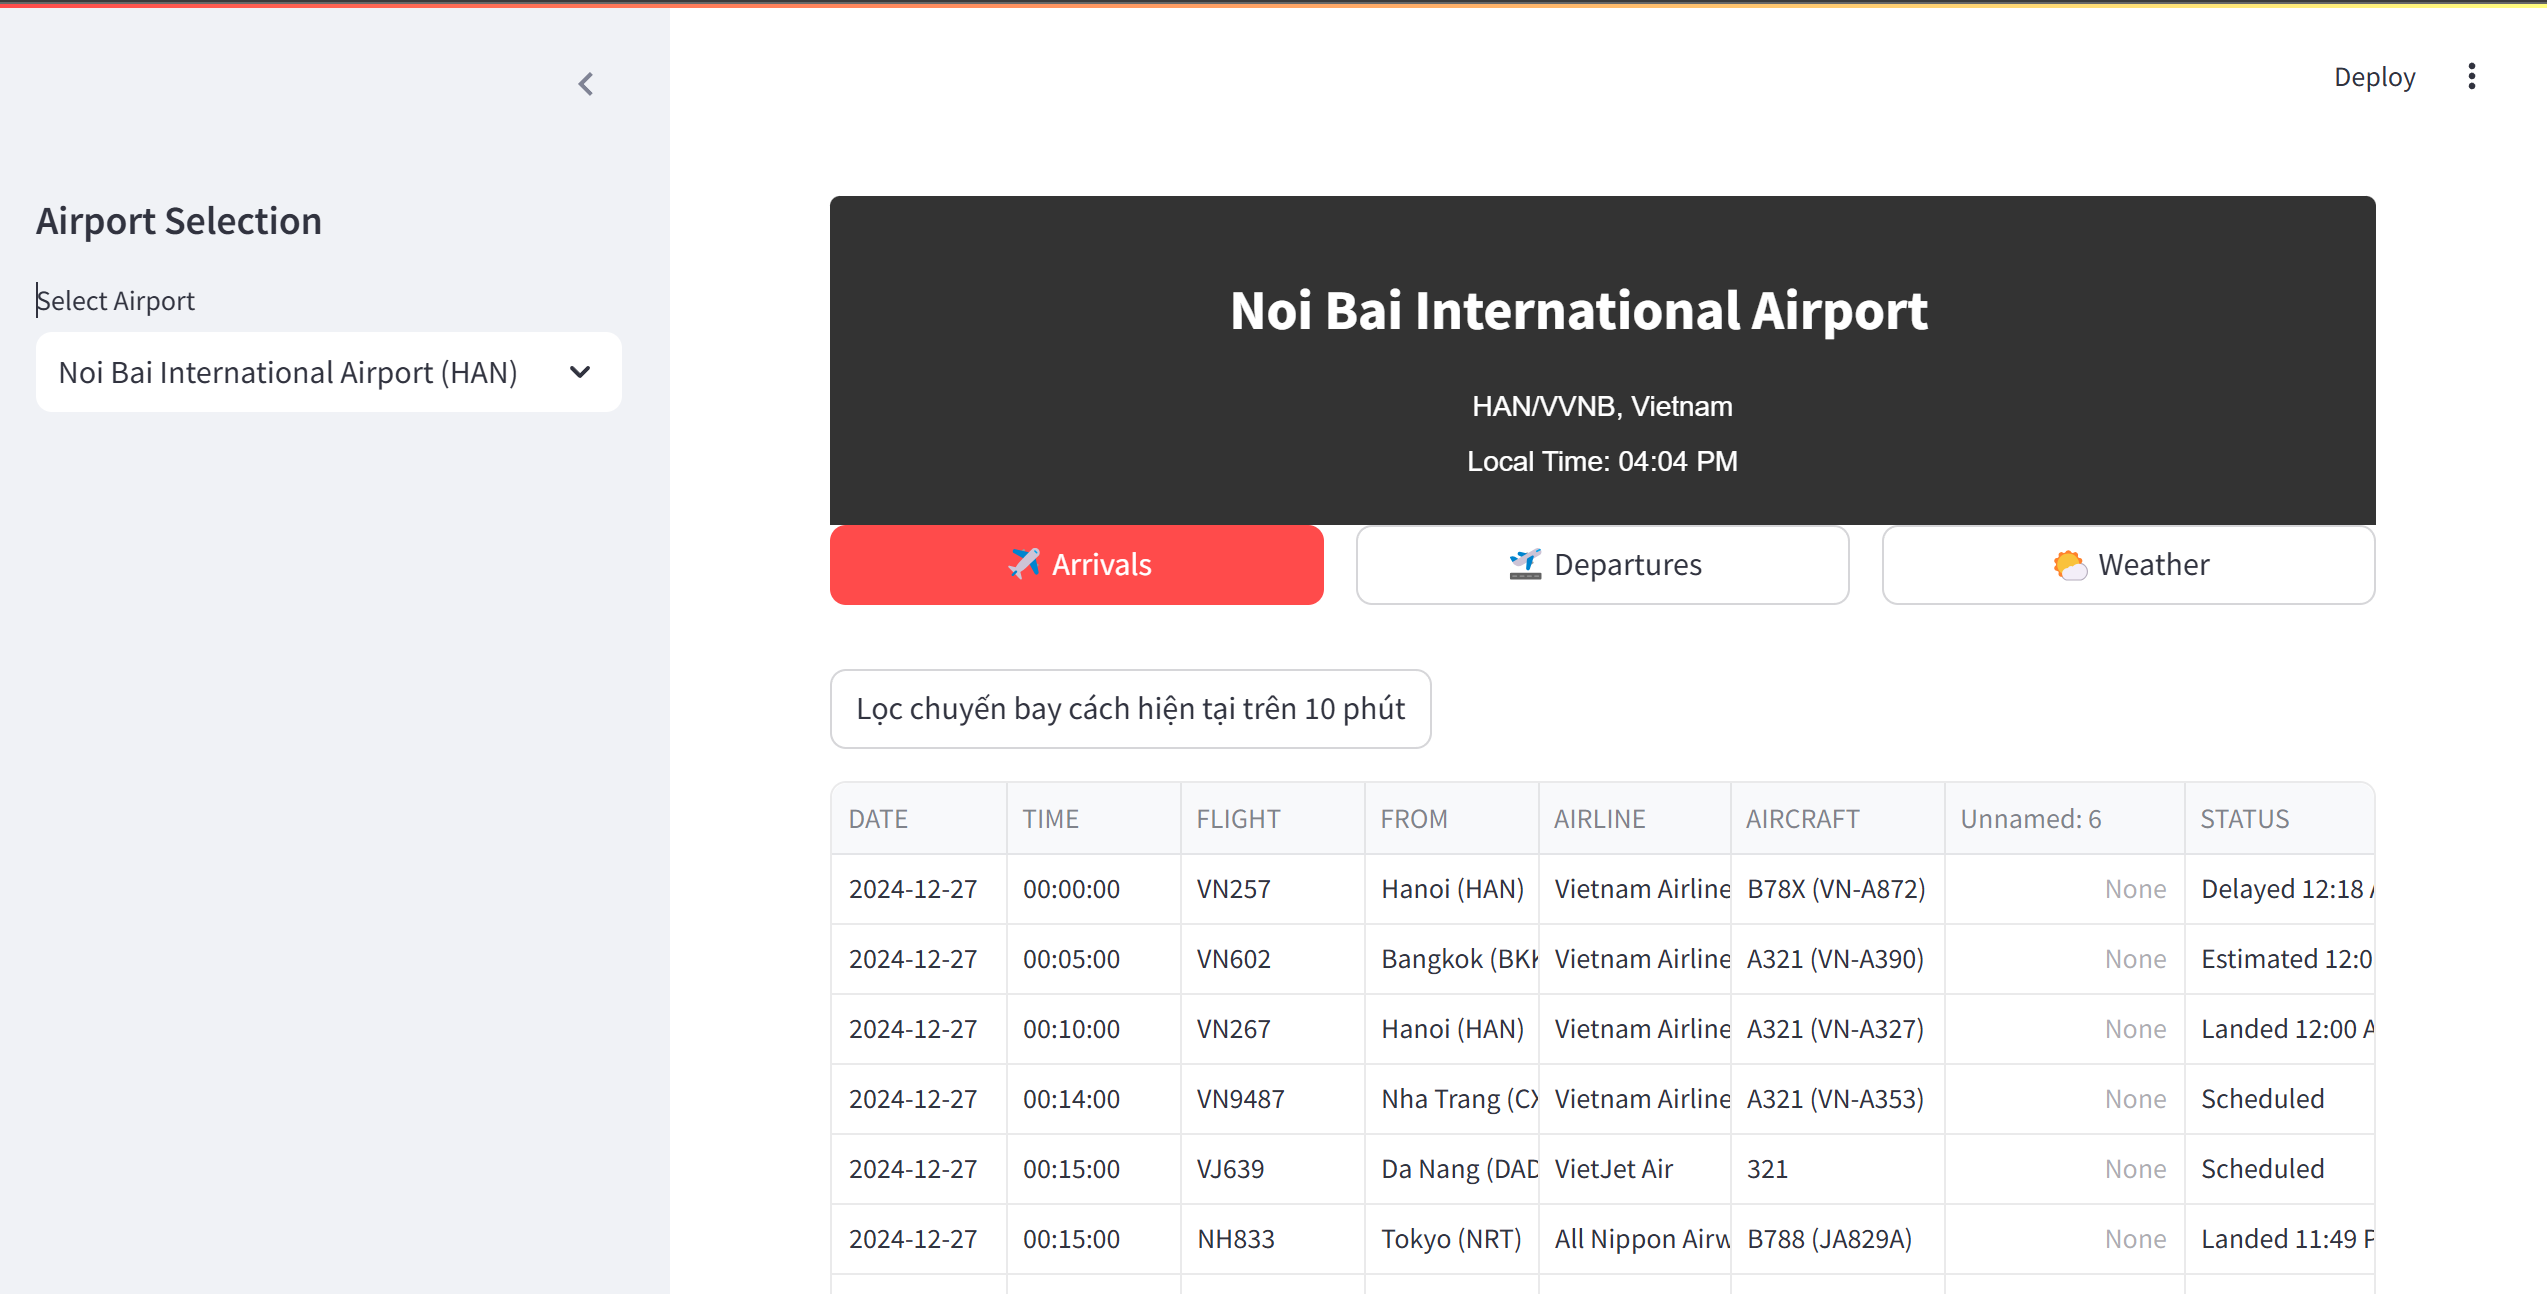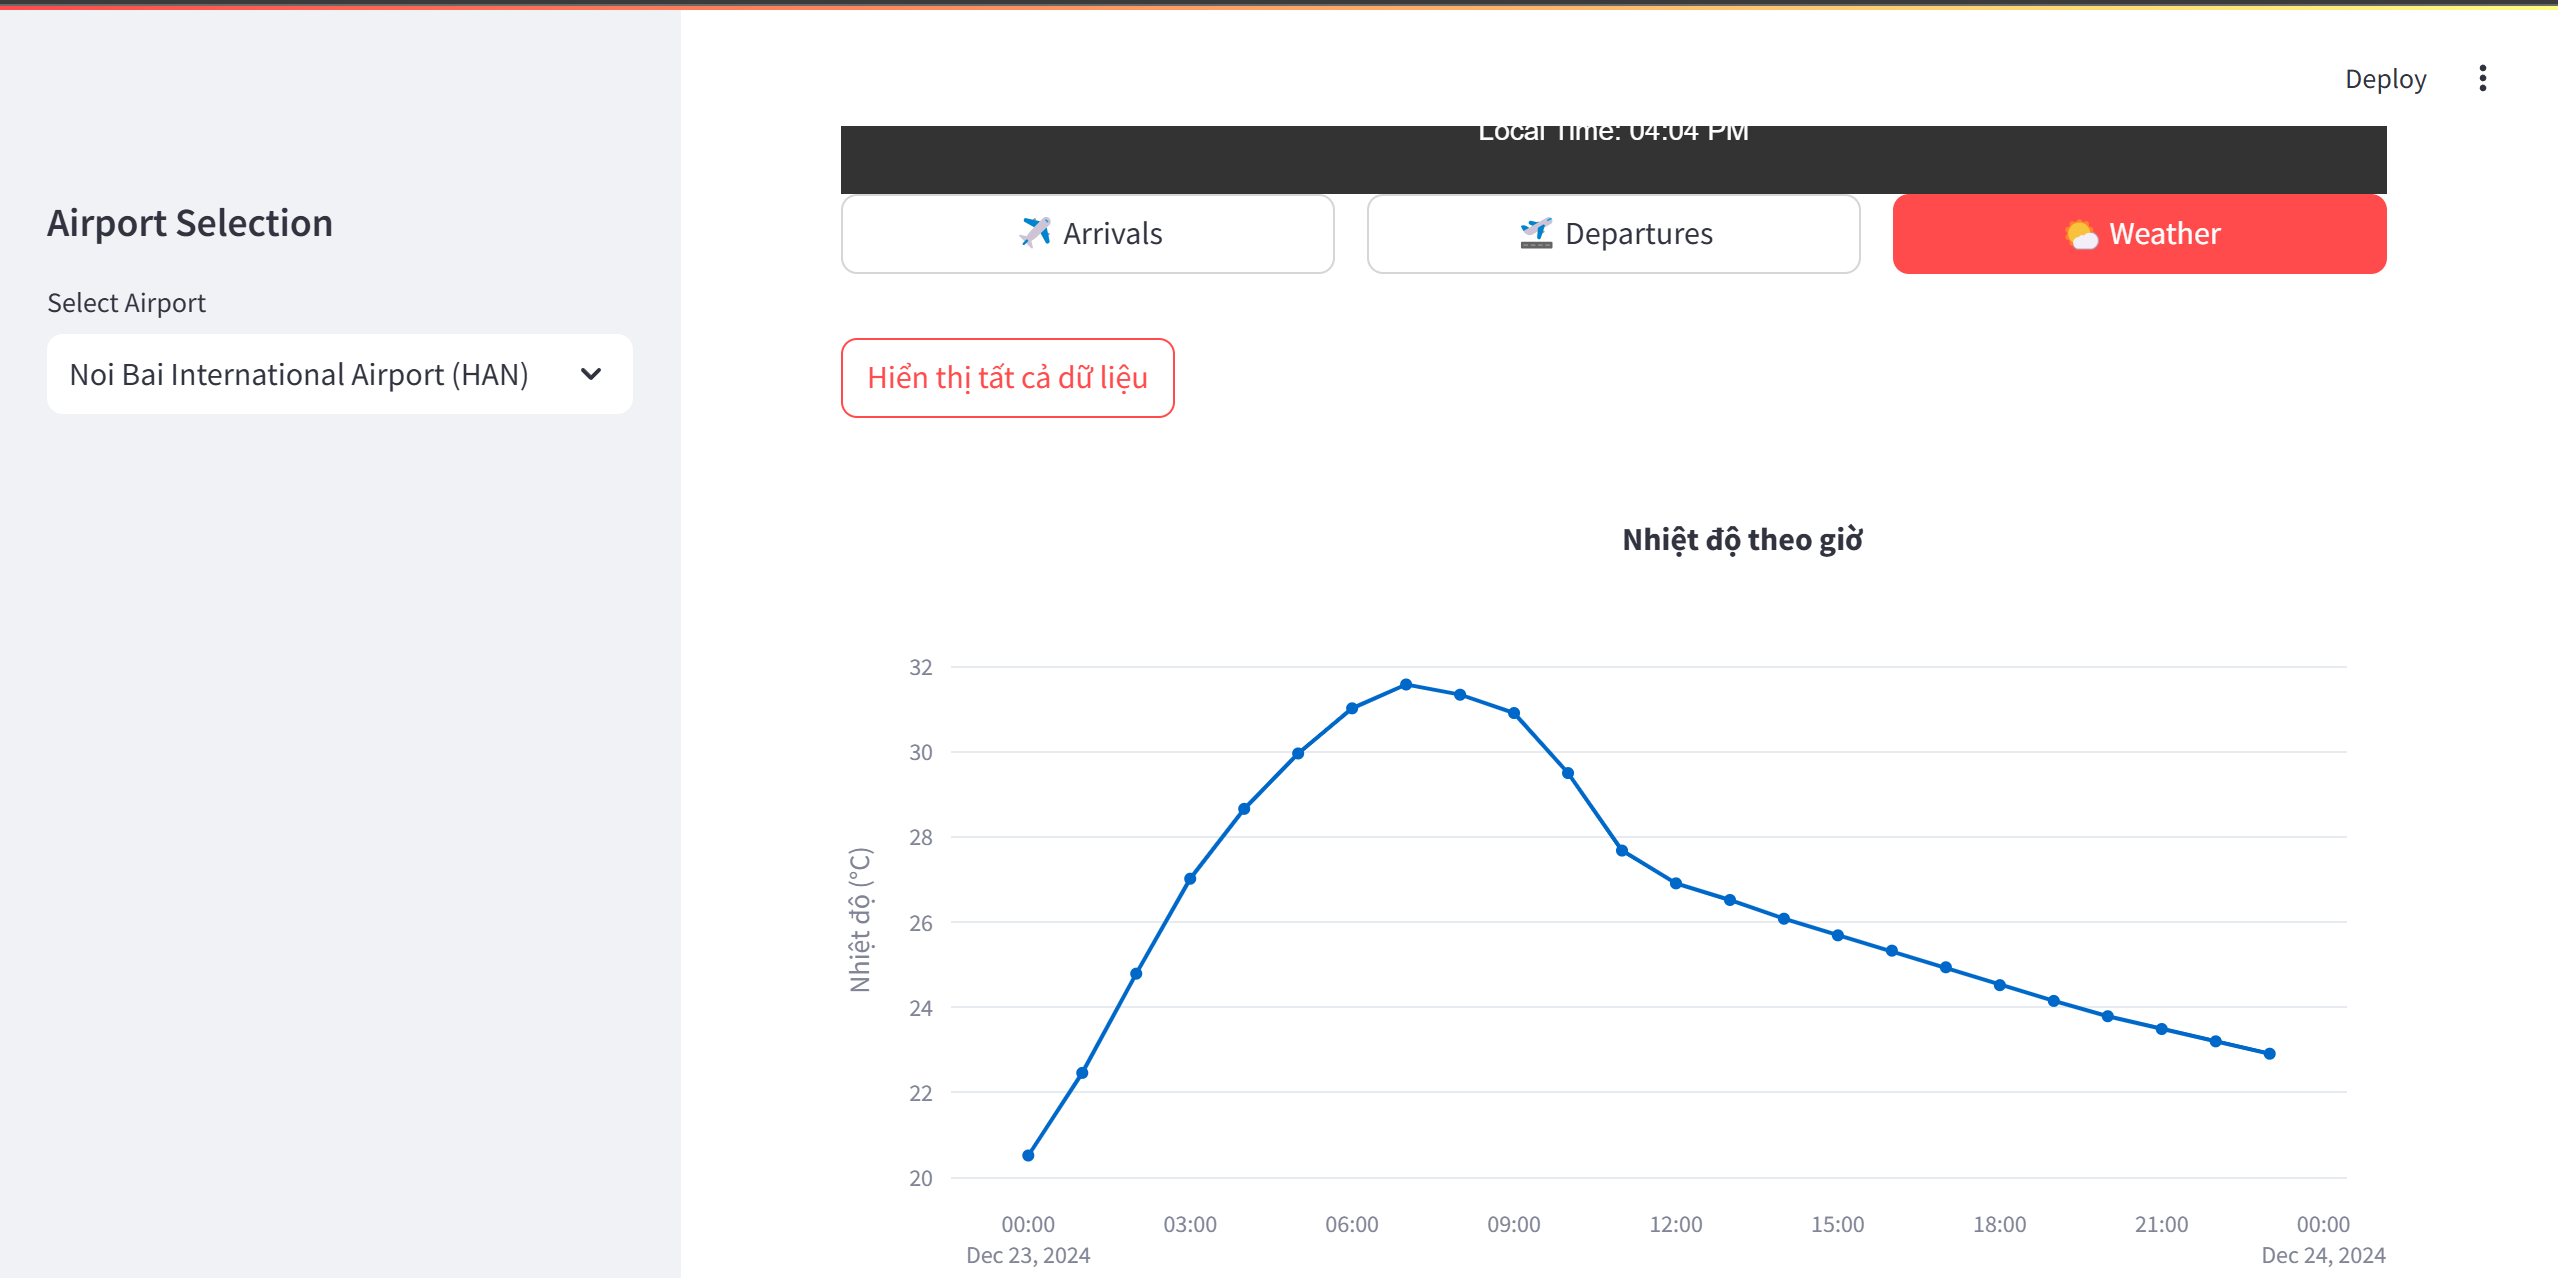

###3. Implementation process

- Feature Engineering:
  - Chuyển đổi thời gian sang định dạng phù hợp.
  - Ghép cột thời tiết.

- Visualization and EDA:
  - Khám phá mối quan hệ giữa các biến và sự chậm trễ chuyến bay.
  - Sử dụng các biểu đồ trực quan như biểu đồ phân tán (scatter plot) và biểu đồ thanh (bar plot).
  - Tính toán mối tương quan.

- Machine Learning:
  - Áp dụng nhiều thuật toán khác nhau cho các mô hình dự đoán.
  - Random Forest Classifier đạt độ chính xác cao nhất ( departure ~ 75,16%, arrival ~ 80,34% ).

- Build an interface:
  - Sử dụng Streamlit để hiển thị các bảng giao diện
  


###4. Final Conclusions

Tóm lại, mô hình đã dự đoán thành công sự chậm trễ chuyến bay với độ chính xác khá cao. Tôi đã thu thập và xử lý dữ liệu, thực hiện xây dựng đặc trưng, trực quan hóa mối quan hệ, và xây dựng các mô hình dự đoán chính xác. Những mô hình này có thể cải thiện hiệu quả hoạt động và nâng cao trải nghiệm quản lý chuyến bay cho cả hãng hàng không và hành khách.